# 1.OBESITY DATASET

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df= pd.read_csv('ObesityDataSet.csv')

In [3]:
def null_check(df):
    null_columns = []
    for column in df.columns:
        print("Column Name:", column)
        print("Column DataType:", df[column].dtype)
        if df[column].dtype != 'float64':
            print("Column unique values:", df[column].unique())
        print("Column has null:", df[column].isnull().any())
        if df[column].isnull().any() == True:
            print("Column Null Count:", df[column].isnull().sum())
            null_columns.append(column)
        print("\n")
    return null_columns

null_cols = null_check(df)

Column Name: Gender
Column DataType: object
Column unique values: ['Female' 'Male']
Column has null: False


Column Name: Age
Column DataType: float64
Column has null: False


Column Name: Height
Column DataType: float64
Column has null: False


Column Name: Weight
Column DataType: float64
Column has null: False


Column Name: family_history_with_overweight
Column DataType: object
Column unique values: ['yes' 'no']
Column has null: False


Column Name: FAVC
Column DataType: object
Column unique values: ['no' 'yes']
Column has null: False


Column Name: FCVC
Column DataType: float64
Column has null: False


Column Name: NCP
Column DataType: float64
Column has null: False


Column Name: CAEC
Column DataType: object
Column unique values: ['Sometimes' 'Frequently' 'Always' 'no']
Column has null: False


Column Name: SMOKE
Column DataType: object
Column unique values: ['no' 'yes']
Column has null: False


Column Name: CH2O
Column DataType: float64
Column has null: False


Column Name: SCC
C

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
# displaying data types, null values, and possible outliers in each column
def dataframe_summary():
    
    # lists
    var_list = df.columns.to_list()
    dtype_list = []
    null_list = []
    
    # looping through columns
    for col in df.columns:
        dtype_list.append(df[col].dtype)
        null_list.append(df[col].isnull().sum())
    
    # outliers IQR
    Q1 = df.quantile(.25)
    Q3 = df.quantile(.75)
    IQR = Q3 - Q1
    k = 1.5
    outlier_list = ((df < (Q1 - k * IQR)) | (df > (Q3 + k * IQR))).sum().to_list()
    
    # stacking lists into dictionary
    dict = {'Variable': var_list, 'Data type': dtype_list, 'Null values': null_list, 'Outliers': outlier_list}
    
    return pd.DataFrame(dict).style.hide_index()
    
dataframe_summary()

C:\Users\lenovo1\AppData\Local\Temp\ipykernel_6712\3884873115.py:17: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(.25)
C:\Users\lenovo1\AppData\Local\Temp\ipykernel_6712\3884873115.py:18: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(.75)
C:\Users\lenovo1\AppData\Local\Temp\ipykernel_6712\3884873115.py:21: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outlier_list = ((df < (Q1 - k * IQR)) | (df > (Q3 + k * IQR))).sum().to_list()
C:\Us

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd

# Function to handle missing values
def missing_value_treatment(df, target):
    df = df.copy()
    if target in df.columns:
        target_data = df[target]  # Preserve target column separately
        df = df.drop(columns=[target])
    else:
        target_data = None
    
    missing_columns = df.columns[df.isna().any()].tolist()
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_cols = list(set(df.columns) - set(numerical_cols))
    
    for col in missing_columns:
        missing_ratio = df[col].isna().sum() / len(df)
        if missing_ratio <= 0.05 and len(df) > 30000:
            df.dropna(subset=[col], inplace=True)
        elif missing_ratio > 0.8:
            df.drop(columns=[col], inplace=True)
        else:
            if col in categorical_cols:
                mode_val = df[col].mode()[0]
                df[col].fillna(mode_val, inplace=True)
            else:
                imputer = IterativeImputer(max_iter=10, random_state=0)
                imputed_data = imputer.fit_transform(df[numerical_cols])
                df[numerical_cols] = pd.DataFrame(imputed_data, columns=numerical_cols)

    df.reset_index(drop=True, inplace=True)
    if target_data is not None:
        df[target] = target_data  # Reattach target column after processing
    print("Missing values treated successfully.")
    return df

# Function to handle duplicate values
def duplicate_value_treatment(df, target):
    df = df.copy()
    if target in df.columns:
        target_data = df[target]
        df = df.drop(columns=[target])
    else:
        target_data = None

    initial_count = len(df)
    df.drop_duplicates(inplace=True)
    final_count = len(df)
    df.reset_index(drop=True, inplace=True)
    
    if target_data is not None:
        df[target] = target_data
    print(f"Duplicate values removed: {initial_count - final_count}")
    return df

# Function to standardize numerical columns
def data_standardization(df, target, scaling_type=1):
    df = df.copy()
    if target in df.columns:
        target_data = df[target]
        df = df.drop(columns=[target])
    else:
        target_data = None

    num_var = [col for col in df.columns if df[col].dtype in ['float64', 'int64']]
    
    if scaling_type == 1:
        scaler = StandardScaler()
    elif scaling_type == 2:
        scaler = MinMaxScaler()
    else:
        print("Invalid scaling type. Choose 1 (StandardScaler) or 2 (MinMaxScaler).")
        return df
    
    for col in num_var:
        df[col] = scaler.fit_transform(df[[col]]).round(2)
    
    if target_data is not None:
        df[target] = target_data
    print(f"Data standardized using {'StandardScaler' if scaling_type == 1 else 'MinMaxScaler'}.")
    return df

# Function to encode categorical columns
def cat_encoding(df, target):
    df = df.copy()
    if target in df.columns:
        target_data = df[target]
        df = df.drop(columns=[target])
    else:
        target_data = None

    cat_var = [col for col in df.columns if df[col].dtype in ['object', 'category']]
    label_encoder = LabelEncoder()
    
    for col in cat_var:
        df[col] = label_encoder.fit_transform(df[col].astype(str))
    
    if target_data is not None:
        df[target] = target_data
    print("Categorical variables encoded successfully.")
    return df

# Main data preprocessing pipeline
def preprocess_data(df, target, scaling_type=1):
    print("Starting data preprocessing...")
    df = missing_value_treatment(df, target)
    df = duplicate_value_treatment(df, target)
    df = data_standardization(df, target, scaling_type)
    df = cat_encoding(df, target)
    print("Data preprocessing completed.")
    return df

# Example Usage:
target = "NObeyesdad"
df = preprocess_data(df, target, scaling_type=1)



Starting data preprocessing...
Missing values treated successfully.
Duplicate values removed: 24
Data standardized using StandardScaler.
Categorical variables encoded successfully.
Data preprocessing completed.


In [6]:
df.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

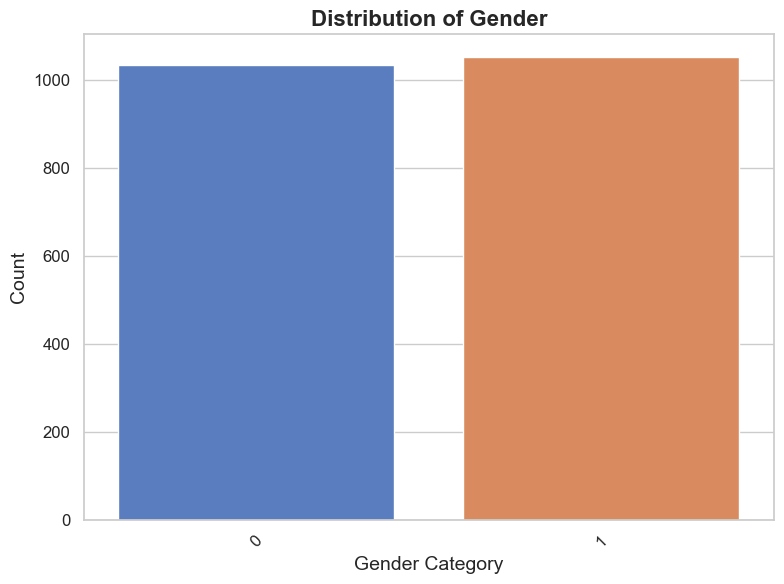

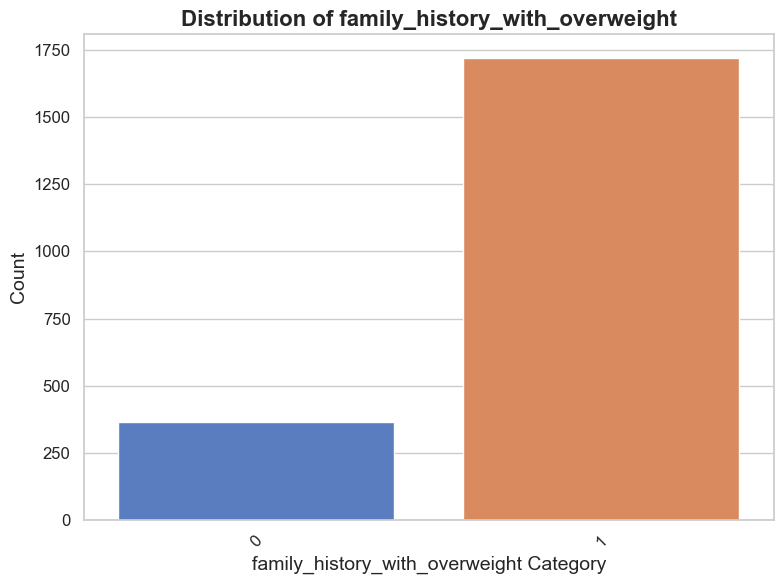

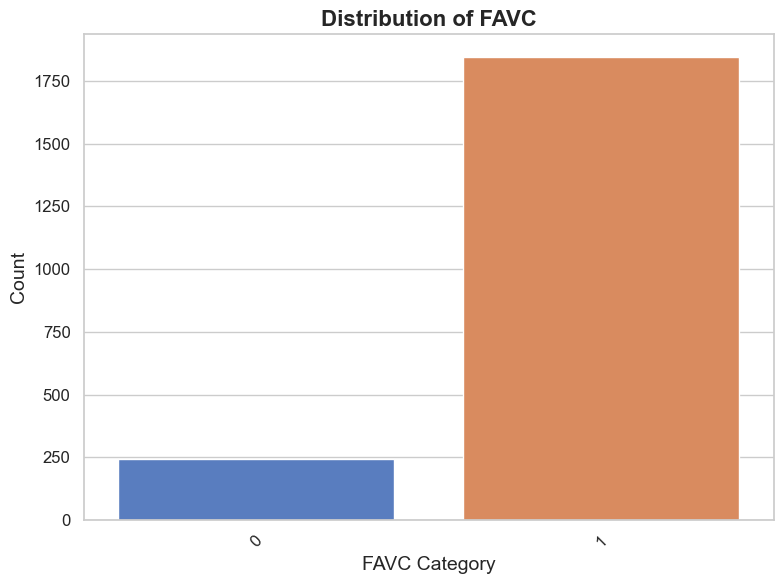

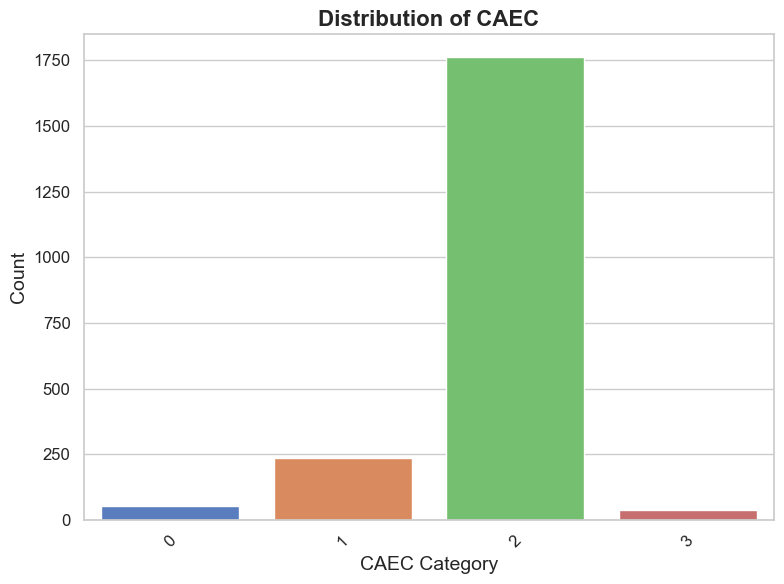

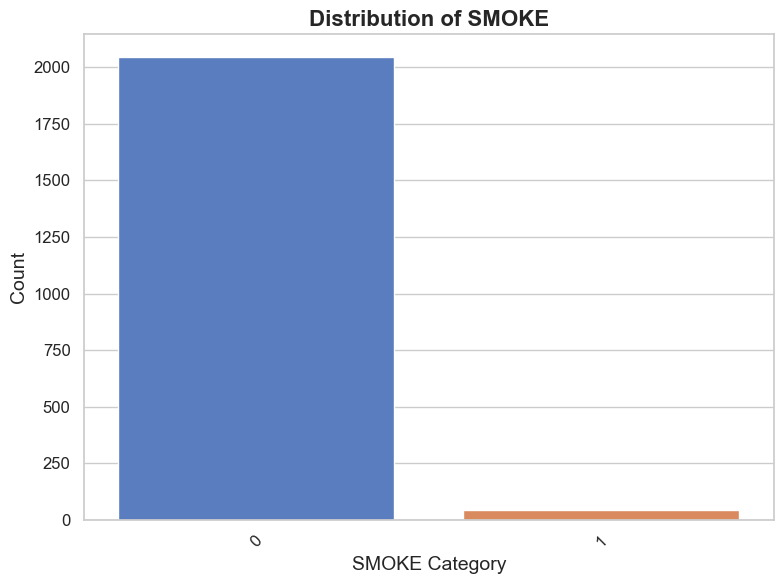

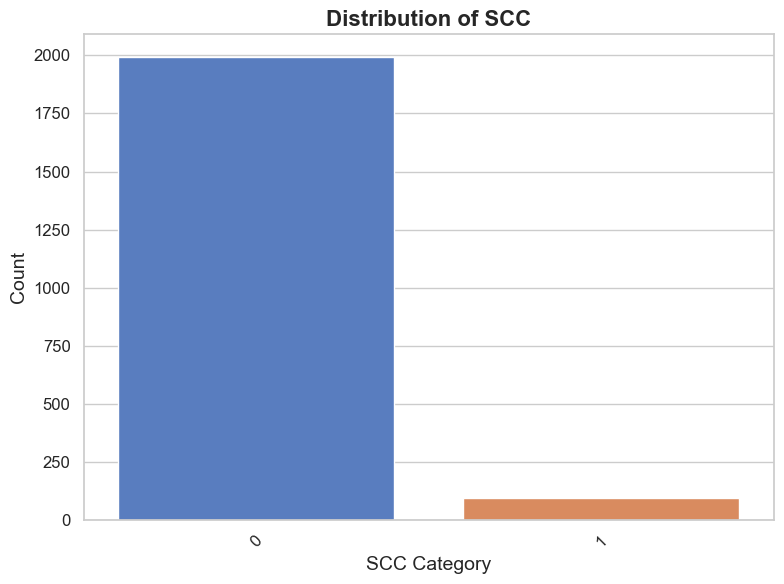

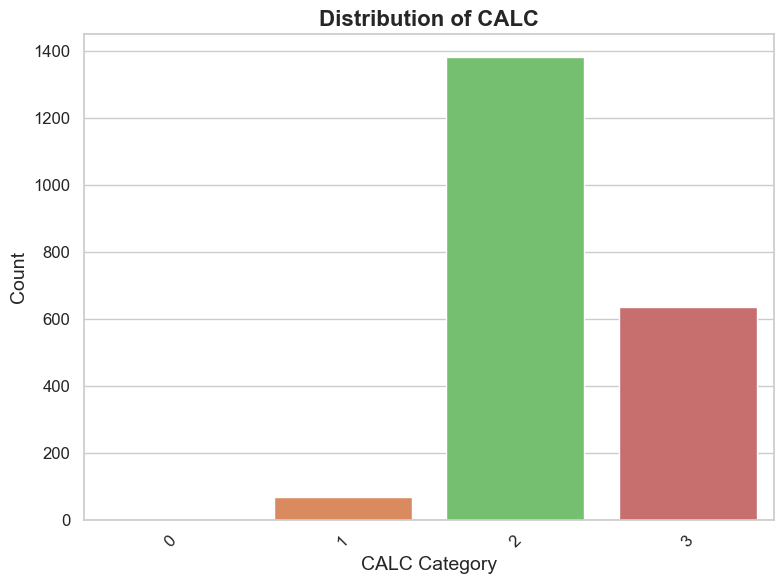

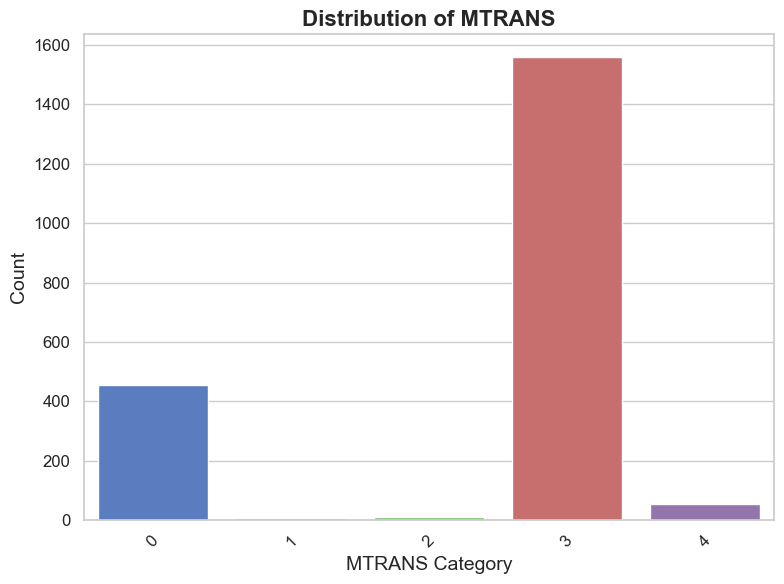

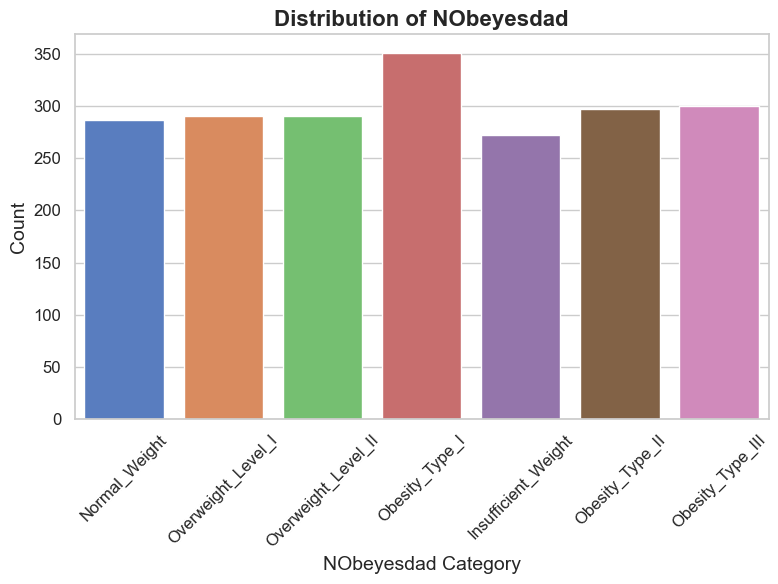

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Loop through all the features and plot count plots
features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']

# Set Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

for f in features:
    plt.figure(figsize=(8, 6))  # Increase figure size for better readability
    sns.countplot(x=f, data=df, palette='muted')  # Apply a muted palette for a balanced look
    
    # Add titles and labels
    plt.title(f'Distribution of {f}', fontsize=16, weight='bold')
    plt.xlabel(f'{f} Category', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    
    # Rotate x-axis labels for better readability and adjust label size
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


<Figure size 800x600 with 0 Axes>

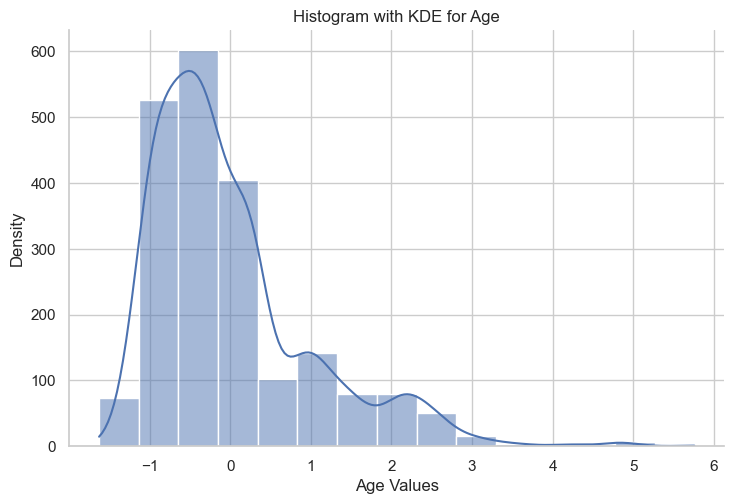

<Figure size 800x600 with 0 Axes>

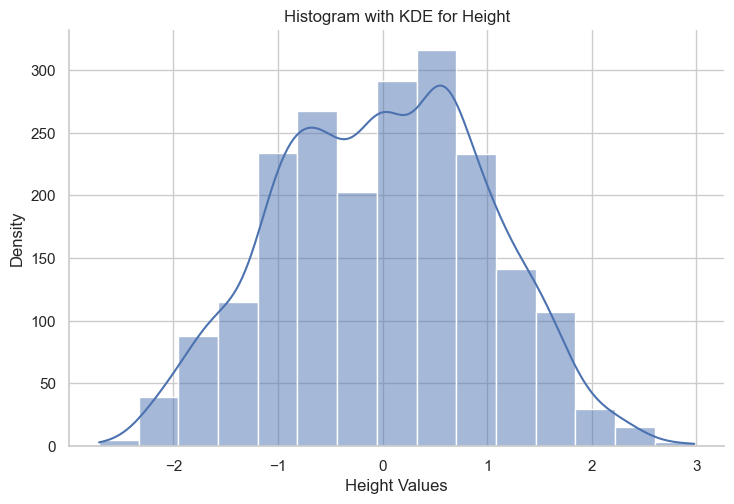

<Figure size 800x600 with 0 Axes>

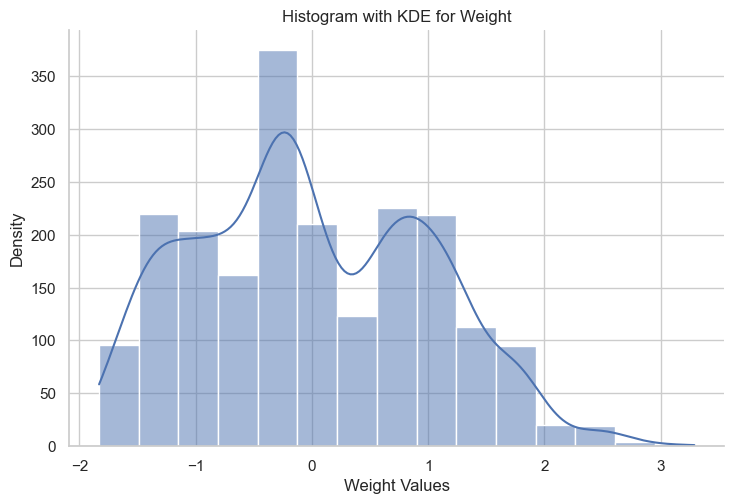

<Figure size 800x600 with 0 Axes>

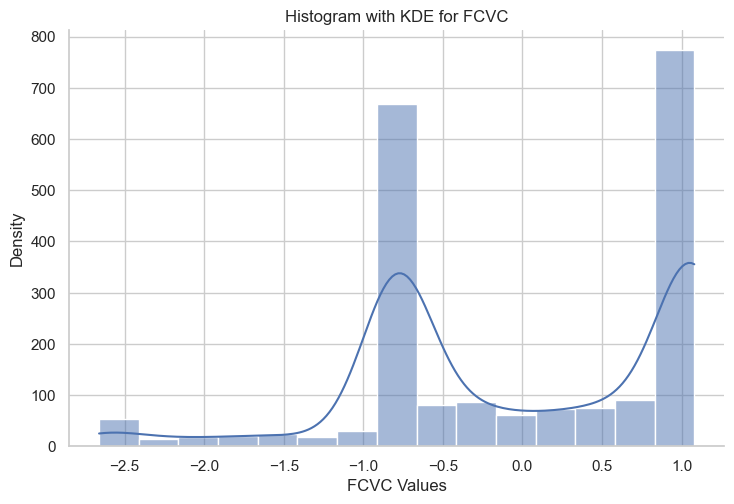

<Figure size 800x600 with 0 Axes>

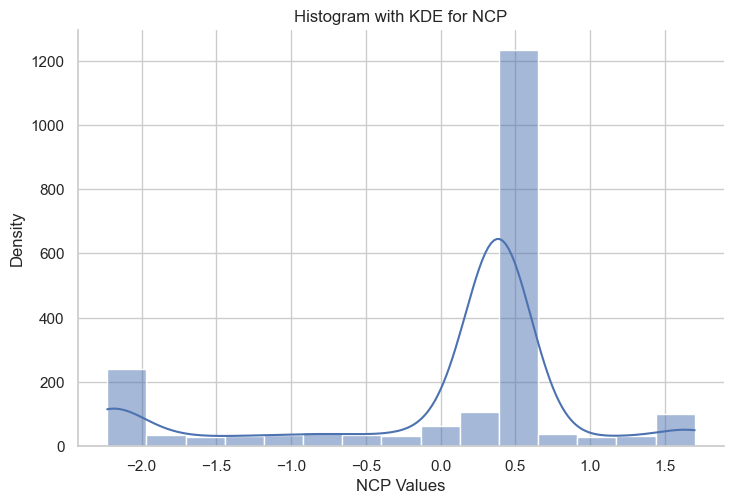

<Figure size 800x600 with 0 Axes>

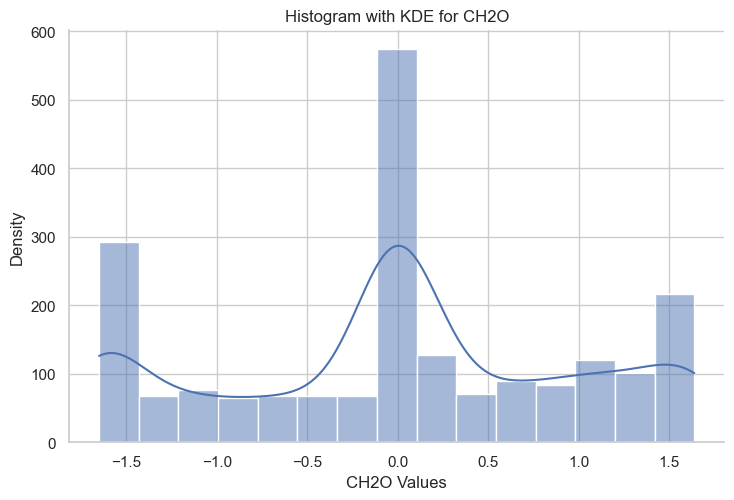

<Figure size 800x600 with 0 Axes>

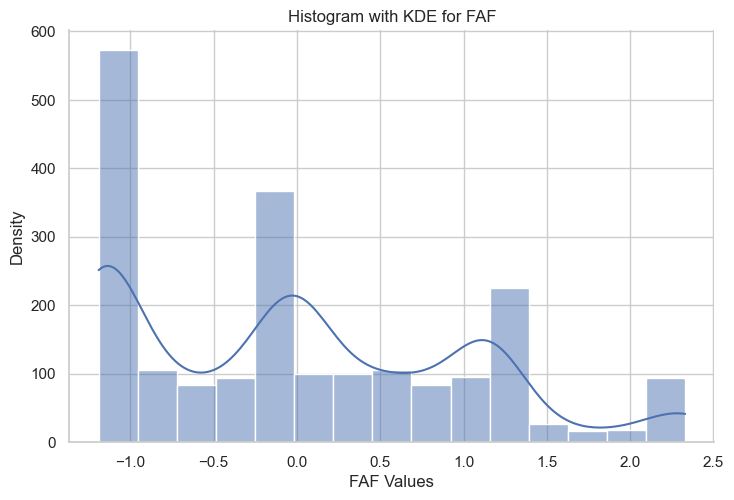

<Figure size 800x600 with 0 Axes>

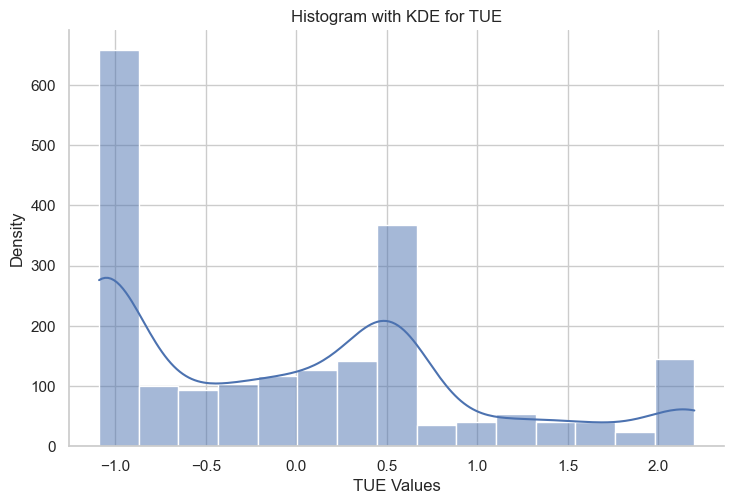

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is a DataFrame containing the features
# Example data (replace 'data' with your actual DataFrame)
num_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']  # List of numeric features

# Plot histogram with KDE for each feature in the 'num_features' list
for feature in num_features:
    plt.figure(figsize=(8, 6))
    sns.displot(df[feature], kde=True, bins=15, aspect=1.5)
    
    # Set titles and labels
    plt.title(f"Histogram with KDE for {feature}")
    plt.xlabel(f"{feature} Values")
    plt.ylabel("Density")
    
    # Display the plot
    plt.show()


In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import pandas as pd

def data_standardization(df, scaling_type=1):
    df = df.copy()
    num_var = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]
    if scaling_type == 1:
        scaler = StandardScaler()
    elif scaling_type == 2:
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid scaling_type. Use 1 for StandardScaler or 2 for MinMaxScaler.")
    df[num_var] = scaler.fit_transform(df[num_var]).round(2)
    return df

def cat_encoding(df):
    df = df.copy()
    cat_var = [col for col in df.columns if pd.api.types.is_categorical_dtype(df[col]) or pd.api.types.is_object_dtype(df[col])]
    label_encoder = LabelEncoder()
    for feature in cat_var:
        df[feature] = label_encoder.fit_transform(df[feature])
    return df

df = cat_encoding(df)
df = data_standardization(df, scaling_type=2)


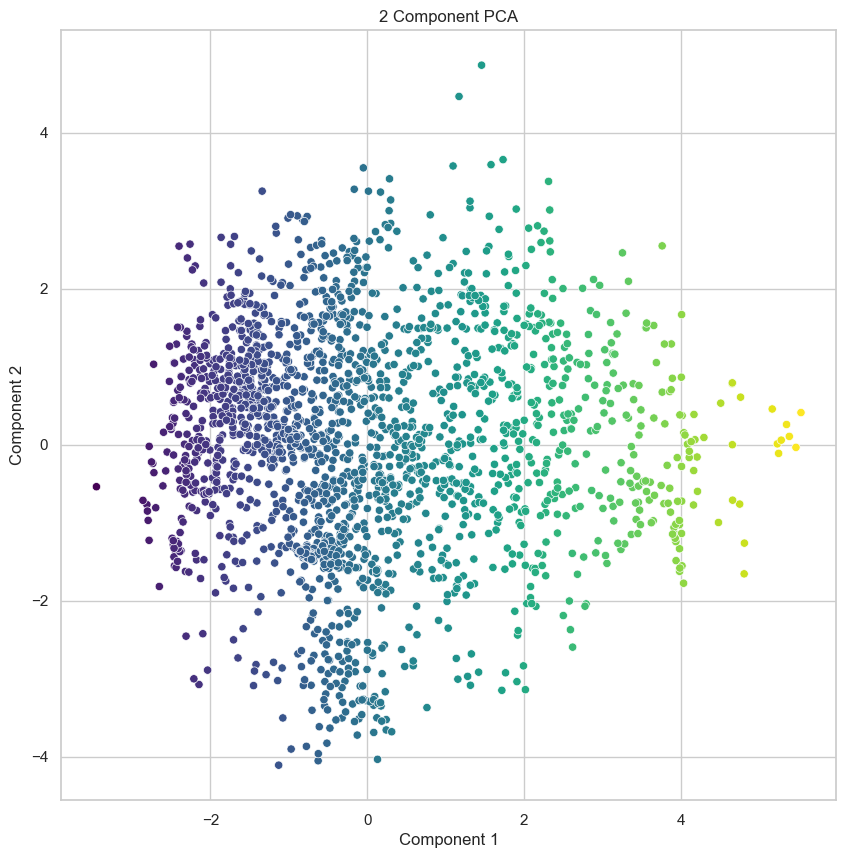

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2087 samples in 0.002s...
[t-SNE] Computed neighbors for 2087 samples in 0.437s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2087
[t-SNE] Computed conditional probabilities for sample 2000 / 2087
[t-SNE] Computed conditional probabilities for sample 2087 / 2087
[t-SNE] Mean sigma: 0.850824
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.282227
[t-SNE] KL divergence after 300 iterations: 1.335065


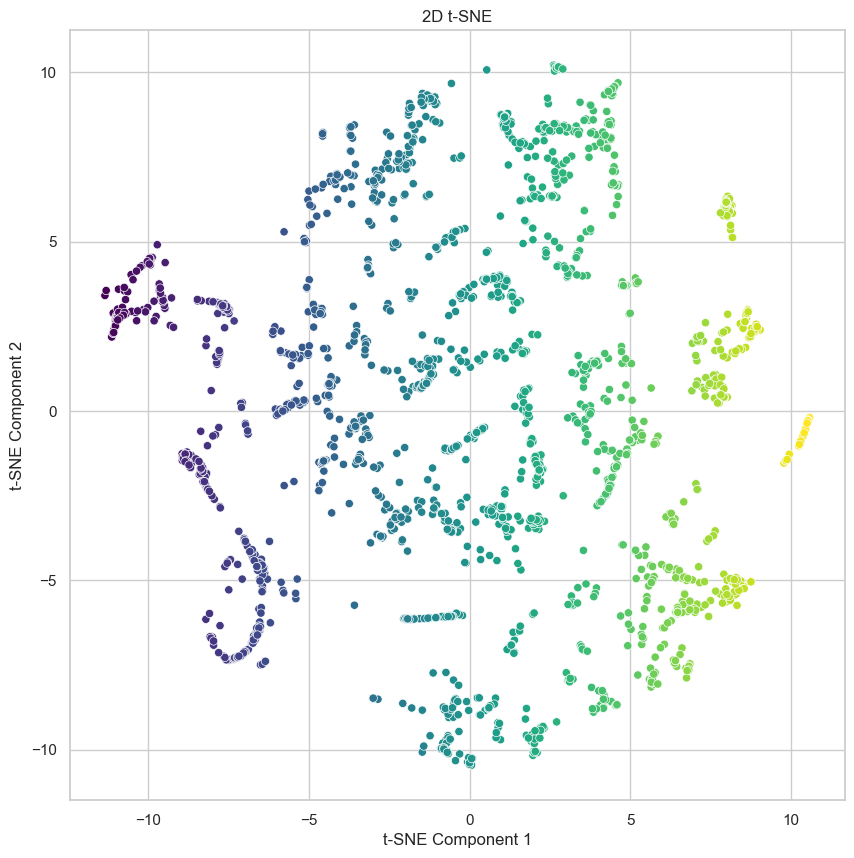

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2087 samples in 0.002s...
[t-SNE] Computed neighbors for 2087 samples in 0.270s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2087
[t-SNE] Computed conditional probabilities for sample 2000 / 2087
[t-SNE] Computed conditional probabilities for sample 2087 / 2087
[t-SNE] Mean sigma: 0.850824
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.087852
[t-SNE] KL divergence after 300 iterations: 1.121901


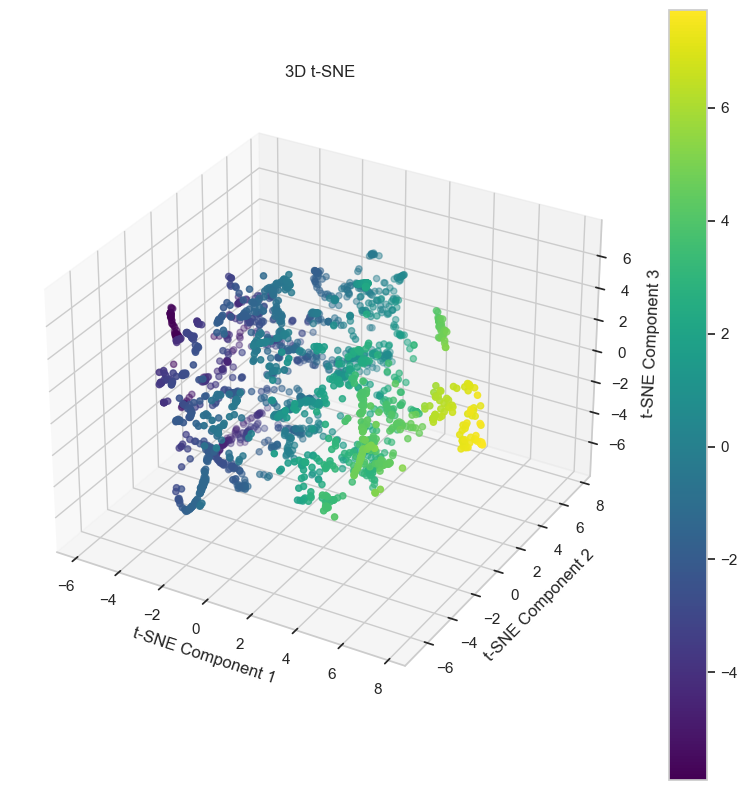

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

def scale_data(df):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    return df_scaled

def pca_2d_visualization(df_scaled):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df_scaled)
    PCA_dataset = pd.DataFrame(data=principalComponents, columns=['component1', 'component2'])
    plt.figure(figsize=(10, 10))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('2 Component PCA')
    sns.scatterplot(x='component1', y='component2', data=PCA_dataset, palette='viridis', hue='component1', legend=False)
    plt.show()

def tsne_2d_visualization(df_scaled, perplexity=40, n_iter=300):
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=n_iter)
    tsne_results = tsne.fit_transform(df_scaled)
    TSNE_dataset = pd.DataFrame(data=tsne_results, columns=['tsne_component1', 'tsne_component2'])
    plt.figure(figsize=(10, 10))
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('2D t-SNE')
    sns.scatterplot(x='tsne_component1', y='tsne_component2', data=TSNE_dataset, palette='viridis', hue='tsne_component1', legend=False)
    plt.show()

def tsne_3d_visualization(df_scaled, perplexity=40, n_iter=300):
    tsne = TSNE(n_components=3, verbose=1, perplexity=perplexity, n_iter=n_iter)
    tsne_results = tsne.fit_transform(df_scaled)
    TSNE_dataset = pd.DataFrame(data=tsne_results, columns=['tsne_component1', 'tsne_component2', 'tsne_component3'])
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    plt.title('3D t-SNE')
    scatter = ax.scatter(xs=TSNE_dataset['tsne_component1'], 
                         ys=TSNE_dataset['tsne_component2'], 
                         zs=TSNE_dataset['tsne_component3'], 
                         c=TSNE_dataset['tsne_component1'], 
                         cmap='viridis')
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_zlabel('t-SNE Component 3')
    plt.colorbar(scatter)
    plt.show()
df_scaled = scale_data(df)
pca_2d_visualization(df_scaled)
tsne_2d_visualization(df_scaled)
tsne_3d_visualization(df_scaled)


Silhouette Score: 0.6684
Davies-Bouldin Index: 0.5218
Calinski-Harabasz Index: 4242.5243


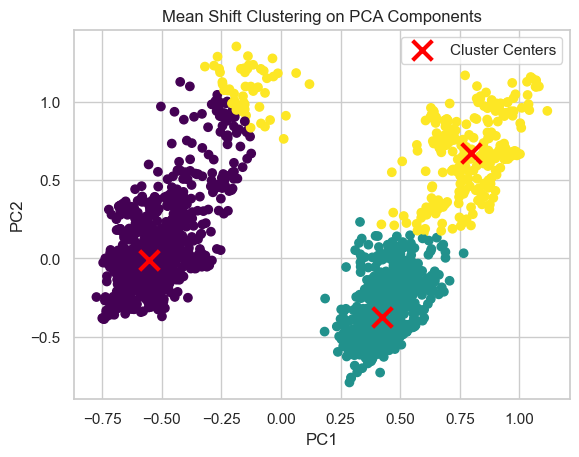

In [12]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# PCA function
def pca_selection(df):
    """
    Applies PCA on the dataset after encoding categorical features.
    Args:
        df (DataFrame): Input dataset.
    Returns:
        DataFrame: Transformed dataset with PCA components.
    """
    # Ensure all categorical columns are encoded
    cat_var = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
    if cat_var:
        label_encoder = LabelEncoder()
        for feature in cat_var:
            df[feature] = label_encoder.fit_transform(df[feature])

    # Apply PCA
    pca = PCA(random_state=123)
    pca_result = pca.fit_transform(df)

    # Create a DataFrame for PCA components
    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
    return pca_df


df = pd.DataFrame(df)

# Step 1: Apply PCA
pca_df = pca_selection(df)

# Step 2: Apply Mean Shift clustering
mean_shift = MeanShift()
clusters = mean_shift.fit_predict(pca_df[['PC1', 'PC2']])

# Step 3: Evaluate clustering metrics
silhouette_avg = silhouette_score(pca_df[['PC1', 'PC2']], clusters)
print(f"Silhouette Score: {silhouette_avg:.4f}")

db_index = davies_bouldin_score(pca_df[['PC1', 'PC2']], clusters)
print(f"Davies-Bouldin Index: {db_index:.4f}")

ch_index = calinski_harabasz_score(pca_df[['PC1', 'PC2']], clusters)
print(f"Calinski-Harabasz Index: {ch_index:.4f}")

# Step 4: Visualize results
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=clusters, cmap='viridis', marker='o')
plt.scatter(mean_shift.cluster_centers_[:, 0], mean_shift.cluster_centers_[:, 1], 
            c='red', marker='x', s=200, linewidths=3, label='Cluster Centers')
plt.title('Mean Shift Clustering on PCA Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


# HYPERPARAMTER TUNING

Bandwidth: 0.50 | Silhouette: 0.6518 | Davies-Bouldin: 0.5289 | Calinski-Harabasz: 3946.2752
Bandwidth: 0.67 | Silhouette: 0.5968 | Davies-Bouldin: 0.7052 | Calinski-Harabasz: 2709.6116
Bandwidth: 0.83 | Silhouette: -1.0000 | Davies-Bouldin: inf | Calinski-Harabasz: -1.0000
Bandwidth: 1.00 | Silhouette: -1.0000 | Davies-Bouldin: inf | Calinski-Harabasz: -1.0000
Bandwidth: 1.17 | Silhouette: -1.0000 | Davies-Bouldin: inf | Calinski-Harabasz: -1.0000
Bandwidth: 1.33 | Silhouette: -1.0000 | Davies-Bouldin: inf | Calinski-Harabasz: -1.0000
Bandwidth: 1.50 | Silhouette: -1.0000 | Davies-Bouldin: inf | Calinski-Harabasz: -1.0000
Bandwidth: 1.67 | Silhouette: -1.0000 | Davies-Bouldin: inf | Calinski-Harabasz: -1.0000
Bandwidth: 1.83 | Silhouette: -1.0000 | Davies-Bouldin: inf | Calinski-Harabasz: -1.0000
Bandwidth: 2.00 | Silhouette: -1.0000 | Davies-Bouldin: inf | Calinski-Harabasz: -1.0000

Best Bandwidth: 0.5


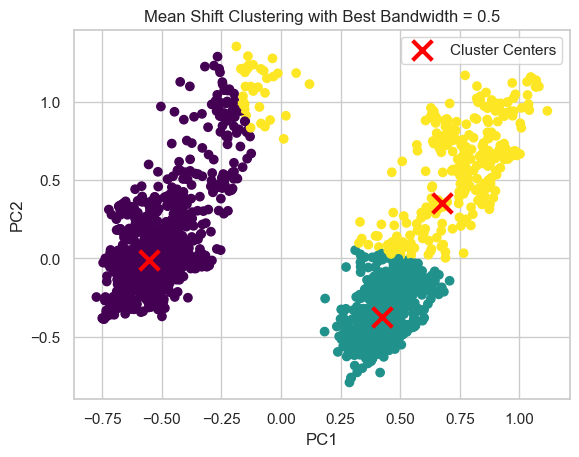

In [17]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# PCA function
def pca_selection(df):
    """
    Applies PCA on the dataset after encoding categorical features.
    Args:
        df (DataFrame): Input dataset.
    Returns:
        DataFrame: Transformed dataset with PCA components.
    """
    # Ensure all categorical columns are encoded
    cat_var = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
    if cat_var:
        label_encoder = LabelEncoder()
        for feature in cat_var:
            df[feature] = label_encoder.fit_transform(df[feature])

    # Apply PCA
    pca = PCA(random_state=123)
    pca_result = pca.fit_transform(df)

    # Create a DataFrame for PCA components
    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
    return pca_df

# Hyperparameter tuning function
def tune_mean_shift(pca_df, bandwidths):
    """
    Tunes the Mean Shift clustering bandwidth and evaluates clustering performance.
    Args:
        pca_df (DataFrame): PCA-transformed dataset.
        bandwidths (list): List of bandwidth values to evaluate.
    Returns:
        dict: Results containing metrics for each bandwidth.
    """
    results = {}
    for bandwidth in bandwidths:
        mean_shift = MeanShift(bandwidth=bandwidth)
        labels = mean_shift.fit_predict(pca_df[['PC1', 'PC2']])

        # Calculate metrics
        if len(set(labels)) > 1:  # Ensure there is more than one cluster
            silhouette_avg = silhouette_score(pca_df[['PC1', 'PC2']], labels)
            db_index = davies_bouldin_score(pca_df[['PC1', 'PC2']], labels)
            ch_index = calinski_harabasz_score(pca_df[['PC1', 'PC2']], labels)
        else:  # Single cluster results are not meaningful
            silhouette_avg, db_index, ch_index = -1, np.inf, -1

        # Save results
        results[bandwidth] = {
            'Silhouette Score': silhouette_avg,
            'Davies-Bouldin Index': db_index,
            'Calinski-Harabasz Index': ch_index,
            'Cluster Centers': mean_shift.cluster_centers_,
            'Labels': labels
        }
        print(f"Bandwidth: {bandwidth:.2f} | Silhouette: {silhouette_avg:.4f} | "
              f"Davies-Bouldin: {db_index:.4f} | Calinski-Harabasz: {ch_index:.4f}")
    return results

df = pd.DataFrame(df)
df1=df.copy()
# Step 1: Apply PCA
pca_df = pca_selection(df)

# Step 2: Define a range of bandwidths to test
bandwidths = np.linspace(0.5, 2.0, 10)

# Step 3: Perform hyperparameter tuning
results = tune_mean_shift(pca_df, bandwidths)

# Step 4: Find the best bandwidth based on Silhouette Score
best_bandwidth = max(results, key=lambda bw: results[bw]['Silhouette Score'])
print(f"\nBest Bandwidth: {best_bandwidth}")

# Step 5: Visualize the best clustering
best_labels = results[best_bandwidth]['Labels']
best_centers = results[best_bandwidth]['Cluster Centers']

plt.scatter(pca_df['PC1'], pca_df['PC2'], c=best_labels, cmap='viridis', marker='o')
plt.scatter(best_centers[:, 0], best_centers[:, 1], 
            c='red', marker='x', s=200, linewidths=3, label='Cluster Centers')
plt.title('Mean Shift Clustering with Best Bandwidth = {}'.format(best_bandwidth))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


# Interpretation

The best bandwidth is 0.50, producing the most meaningful clustering with distinct and well-separated groups into three clusters

Increasing the bandwidth beyond 0.67 negatively impacts clustering quality, leading to merged or poorly-defined clusters.

# RADAR CHART

Silhouette Score: 0.6518
Davies-Bouldin Index: 0.5289
Calinski-Harabasz Index: 3946.2752


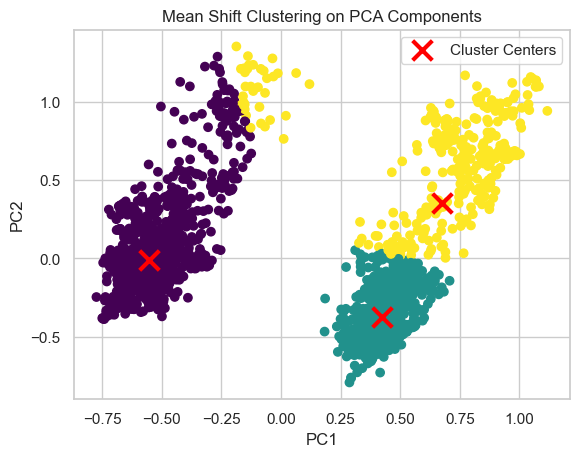

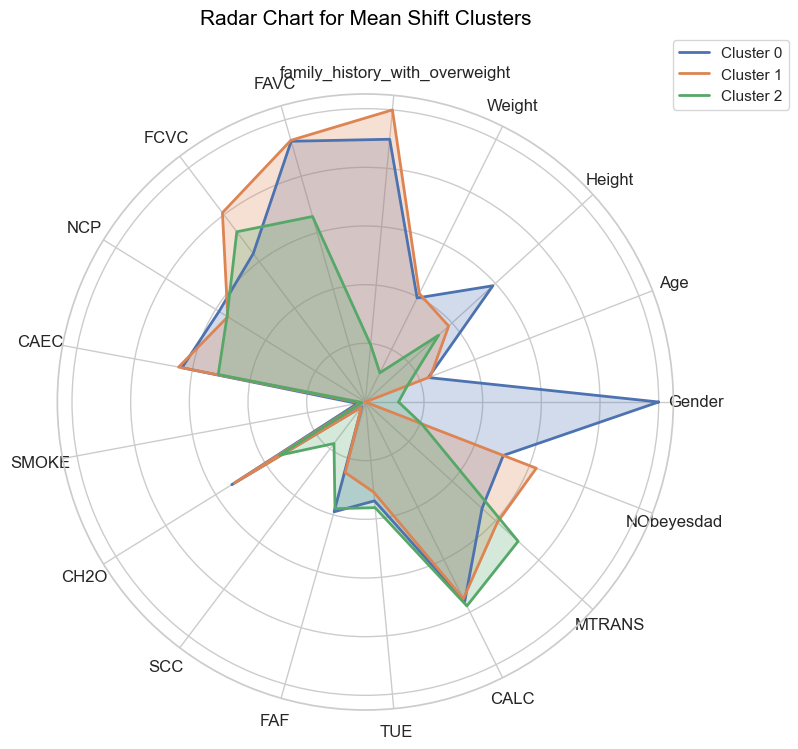

In [18]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# PCA function
def pca_selection(df):
    """
    Applies PCA on the dataset after encoding categorical features.
    Args:
        df (DataFrame): Input dataset.
    Returns:
        DataFrame: Transformed dataset with PCA components.
    """
    # Ensure all categorical columns are encoded
    cat_var = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
    if cat_var:
        label_encoder = LabelEncoder()
        for feature in cat_var:
            df[feature] = label_encoder.fit_transform(df[feature])

    # Apply PCA
    pca = PCA(random_state=123)
    pca_result = pca.fit_transform(df)

    # Create a DataFrame for PCA components
    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
    return pca_df

# Function to plot radar chart for a given cluster type
def plot_radar_chart(df, cluster_column, title='Radar Chart'):
    # Calculate the mean of each feature by cluster
    cluster_means = df.groupby(cluster_column).mean()
    
    # Define labels (features) and number of variables
    labels = cluster_means.columns
    num_vars = len(labels)
    
    # Setup angles for radar chart (spaced equally around a circle)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    
    # The plot needs to be a complete loop, so we repeat the first angle at the end
    angles += angles[:1]
    
    # Plotting radar chart for each cluster
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Plot each cluster
    for idx, row in cluster_means.iterrows():
        values = row.tolist()
        values += values[:1]  # Complete the loop by adding the start value at the end
        ax.plot(angles, values, label=f'Cluster {idx}', linewidth=2)
        ax.fill(angles, values, alpha=0.25)
    
    # Set up chart attributes
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_yticklabels([])
    ax.set_title(title, size=15, color='black', y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    
    plt.show()

# Step 1: Prepare your dataset (replace this with your actual dataset)
df = pd.DataFrame(df)  # Replace 'f' with your actual data
df1=df.copy()
# Step 2: Apply PCA
pca_df = pca_selection(df)

# Step 3: Apply Mean Shift Clustering
mean_shift = MeanShift(bandwidth=0.5)  # Using the best bandwidth found
clusters = mean_shift.fit_predict(pca_df[['PC1', 'PC2']])

# Step 4: Add the cluster labels as a new column in df1
df1['MeanShift_Cluster'] = clusters  # Add Mean Shift clusters to df1

# Step 5: Evaluate clustering metrics
silhouette_avg = silhouette_score(pca_df[['PC1', 'PC2']], clusters)
print(f"Silhouette Score: {silhouette_avg:.4f}")

db_index = davies_bouldin_score(pca_df[['PC1', 'PC2']], clusters)
print(f"Davies-Bouldin Index: {db_index:.4f}")

ch_index = calinski_harabasz_score(pca_df[['PC1', 'PC2']], clusters)
print(f"Calinski-Harabasz Index: {ch_index:.4f}")

# Step 6: Visualize Mean Shift Clustering
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=clusters, cmap='viridis', marker='o')
plt.scatter(mean_shift.cluster_centers_[:, 0], mean_shift.cluster_centers_[:, 1], 
            c='red', marker='x', s=200, linewidths=3, label='Cluster Centers')
plt.title('Mean Shift Clustering on PCA Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

# Step 7: Plot Radar Chart for Mean Shift Clusters
plot_radar_chart(df1, 'MeanShift_Cluster', title='Radar Chart for Mean Shift Clusters')


# CONCLUSION

Cluster 0: May represent a healthier or physically active group based on lower weight-related values and higher family-history awareness.

Cluster 1: Likely individuals with higher dietary concerns and weight-related features.

Cluster 2: Appears more balanced but with slightly distinct patterns in physical activity and food-related features.

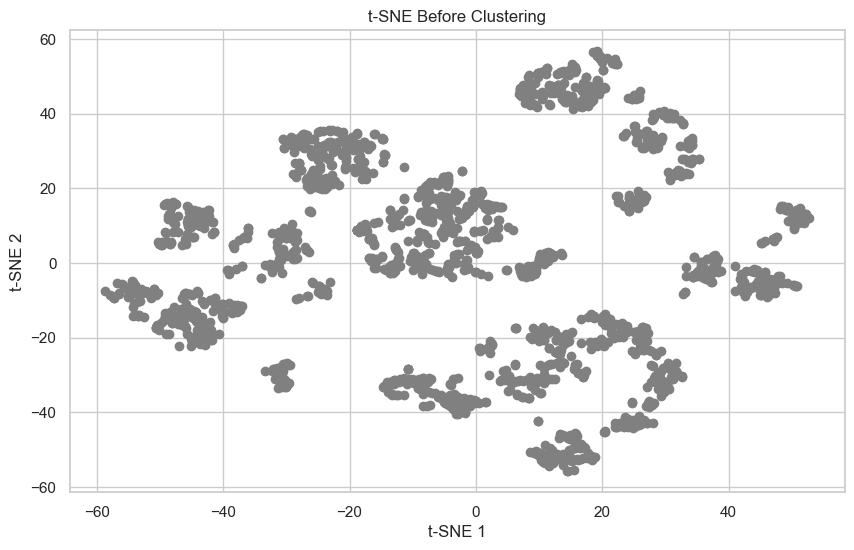

Silhouette Score: 0.7962
Davies-Bouldin Index: 0.3070
Calinski-Harabasz Index: 12407.8948


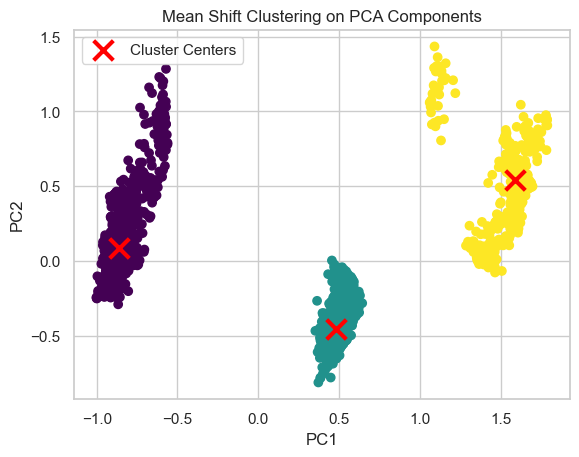

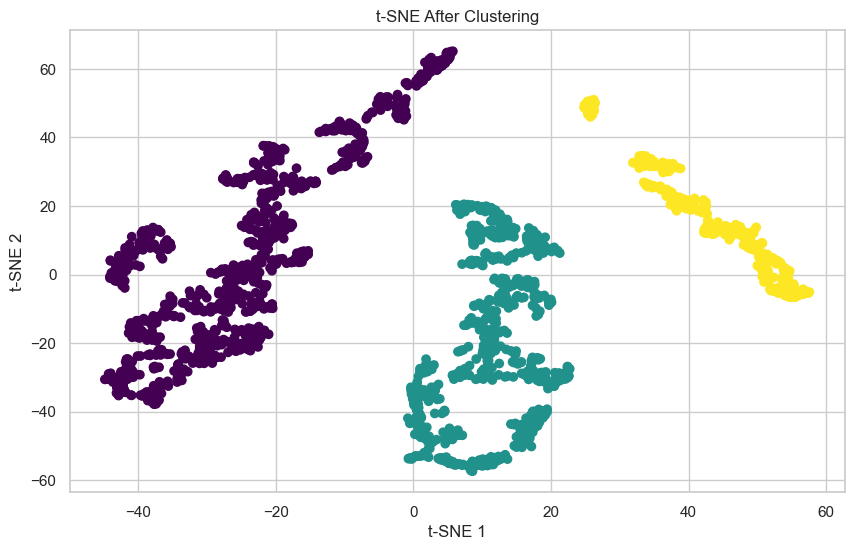

In [19]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# PCA function
def pca_selection(df):
    """
    Applies PCA on the dataset after encoding categorical features.
    Args:
        df (DataFrame): Input dataset.
    Returns:
        DataFrame: Transformed dataset with PCA components.
    """
    # Ensure all categorical columns are encoded
    cat_var = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
    if cat_var:
        label_encoder = LabelEncoder()
        for feature in cat_var:
            df[feature] = label_encoder.fit_transform(df[feature])

    # Apply PCA
    pca = PCA(random_state=123)
    pca_result = pca.fit_transform(df)

    # Create a DataFrame for PCA components
    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
    return pca_df

# Step 1: Prepare your dataset (replace this with your actual dataset)
df = pd.DataFrame(df)  # Replace 'f' with your actual data
df=df1.copy()
# Step 2: Apply PCA
pca_df = pca_selection(df)

# Step 3: Apply t-SNE before clustering
tsne = TSNE(n_components=2, random_state=123)
tsne_result = tsne.fit_transform(pca_df)

# Visualize t-SNE before clustering
plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='gray', marker='o')
plt.title('t-SNE Before Clustering')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.show()

# Step 4: Apply Mean Shift Clustering
mean_shift = MeanShift(bandwidth=0.5)  # Using the best bandwidth found
clusters = mean_shift.fit_predict(pca_df[['PC1', 'PC2']])

# Step 5: Add the cluster labels as a new column in df1
df1['MeanShift_Cluster'] = clusters  # Add Mean Shift clusters to df1

# Step 6: Evaluate clustering metrics
silhouette_avg = silhouette_score(pca_df[['PC1', 'PC2']], clusters)
print(f"Silhouette Score: {silhouette_avg:.4f}")

db_index = davies_bouldin_score(pca_df[['PC1', 'PC2']], clusters)
print(f"Davies-Bouldin Index: {db_index:.4f}")

ch_index = calinski_harabasz_score(pca_df[['PC1', 'PC2']], clusters)
print(f"Calinski-Harabasz Index: {ch_index:.4f}")

# Step 7: Visualize Mean Shift Clustering results on PCA components
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=clusters, cmap='viridis', marker='o')
plt.scatter(mean_shift.cluster_centers_[:, 0], mean_shift.cluster_centers_[:, 1], 
            c='red', marker='x', s=200, linewidths=3, label='Cluster Centers')
plt.title('Mean Shift Clustering on PCA Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

# Step 8: Apply t-SNE after clustering for visualization
tsne_result_after = tsne.fit_transform(pca_df[['PC1', 'PC2']])  # Apply t-SNE to the PCA components after clustering

# Visualize t-SNE after clustering
plt.figure(figsize=(10, 6))
plt.scatter(tsne_result_after[:, 0], tsne_result_after[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('t-SNE After Clustering')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.show()


# 2.Customer Dataset

In [20]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the file path
df = pd.read_csv("CC GENERAL.csv")


# Display the first few rows of the dataset
print(df.head())

  CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000       

In [21]:
df = pd.read_csv("CC GENERAL.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [22]:
# This function performs a missing value analysis on each column of the dataset, helps you decide on what to do in cleaning process
def null_check(df):
    null_columns = []
    for column in df.columns:
        print("Column Name:", column)
        print("Column DataType:", df[column].dtype)
        if df[column].dtype != 'float64':
            print("Column unique values:", df[column].unique())
        print("Column has null:", df[column].isnull().any())
        if df[column].isnull().any() == True:
            print("Column Null Count:", df[column].isnull().sum())
            null_columns.append(column)
        print("\n")
    return null_columns

null_cols = null_check(df)

Column Name: CUST_ID
Column DataType: object
Column unique values: ['C10001' 'C10002' 'C10003' ... 'C19188' 'C19189' 'C19190']
Column has null: False


Column Name: BALANCE
Column DataType: float64
Column has null: False


Column Name: BALANCE_FREQUENCY
Column DataType: float64
Column has null: False


Column Name: PURCHASES
Column DataType: float64
Column has null: False


Column Name: ONEOFF_PURCHASES
Column DataType: float64
Column has null: False


Column Name: INSTALLMENTS_PURCHASES
Column DataType: float64
Column has null: False


Column Name: CASH_ADVANCE
Column DataType: float64
Column has null: False


Column Name: PURCHASES_FREQUENCY
Column DataType: float64
Column has null: False


Column Name: ONEOFF_PURCHASES_FREQUENCY
Column DataType: float64
Column has null: False


Column Name: PURCHASES_INSTALLMENTS_FREQUENCY
Column DataType: float64
Column has null: False


Column Name: CASH_ADVANCE_FREQUENCY
Column DataType: float64
Column has null: False


Column Name: CASH_ADVANCE_

In [23]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
# displaying data types, null values, and possible outliers in each column
def dataframe_summary():
    
    # lists
    var_list = df.columns.to_list()
    dtype_list = []
    null_list = []
    
    # looping through columns
    for col in df.columns:
        dtype_list.append(df[col].dtype)
        null_list.append(df[col].isnull().sum())
    
    # outliers IQR
    Q1 = df.quantile(.25)
    Q3 = df.quantile(.75)
    IQR = Q3 - Q1
    k = 1.5
    outlier_list = ((df < (Q1 - k * IQR)) | (df > (Q3 + k * IQR))).sum().to_list()
    
    # stacking lists into dictionary
    dict = {'Variable': var_list, 'Data type': dtype_list, 'Null values': null_list, 'Outliers': outlier_list}
    
    return pd.DataFrame(dict).style.hide_index()
    
dataframe_summary()

C:\Users\lenovo1\AppData\Local\Temp\ipykernel_6712\3884873115.py:17: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(.25)
C:\Users\lenovo1\AppData\Local\Temp\ipykernel_6712\3884873115.py:18: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(.75)
C:\Users\lenovo1\AppData\Local\Temp\ipykernel_6712\3884873115.py:21: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outlier_list = ((df < (Q1 - k * IQR)) | (df > (Q3 + k * IQR))).sum().to_list()
C:\Us

In [24]:
df = df.drop(['CUST_ID'],axis = 1)


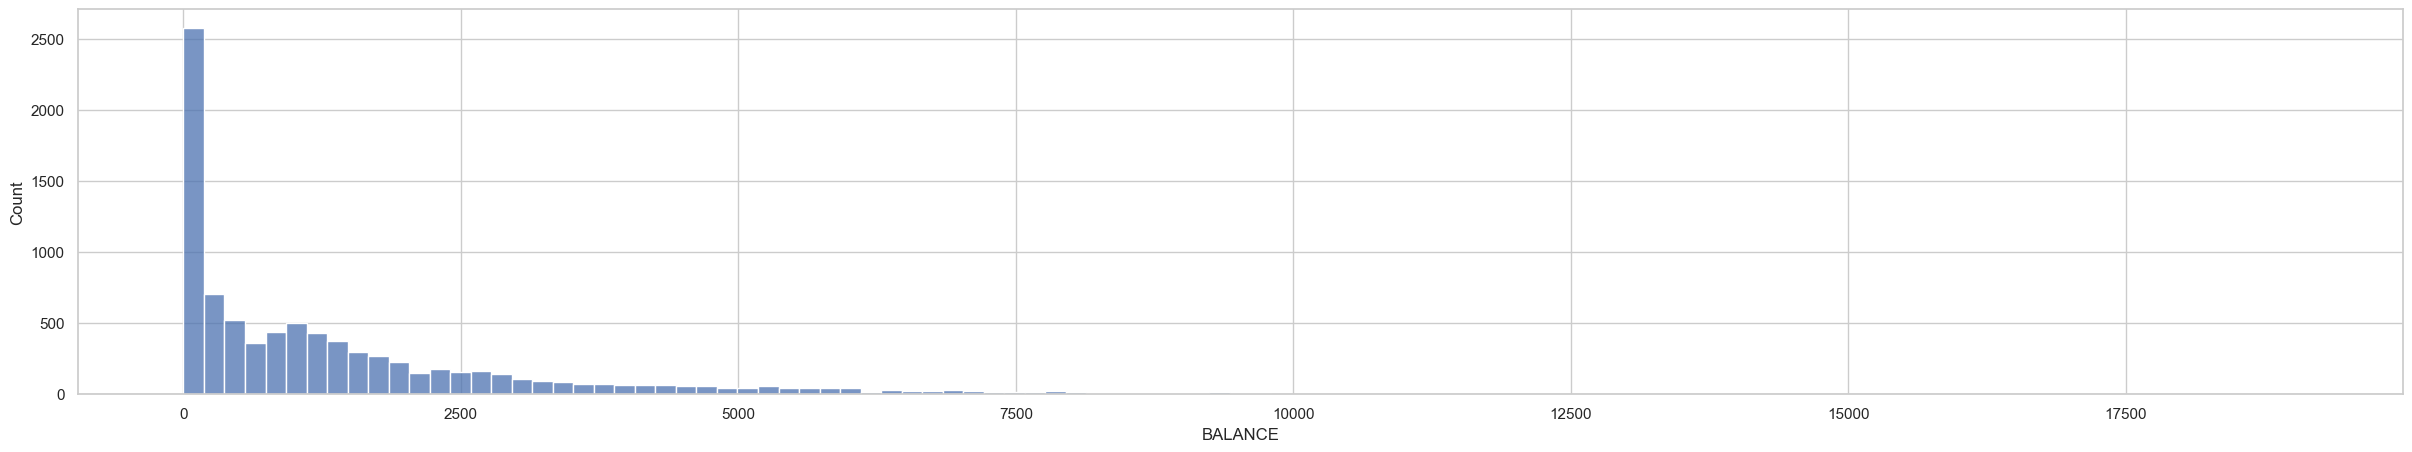

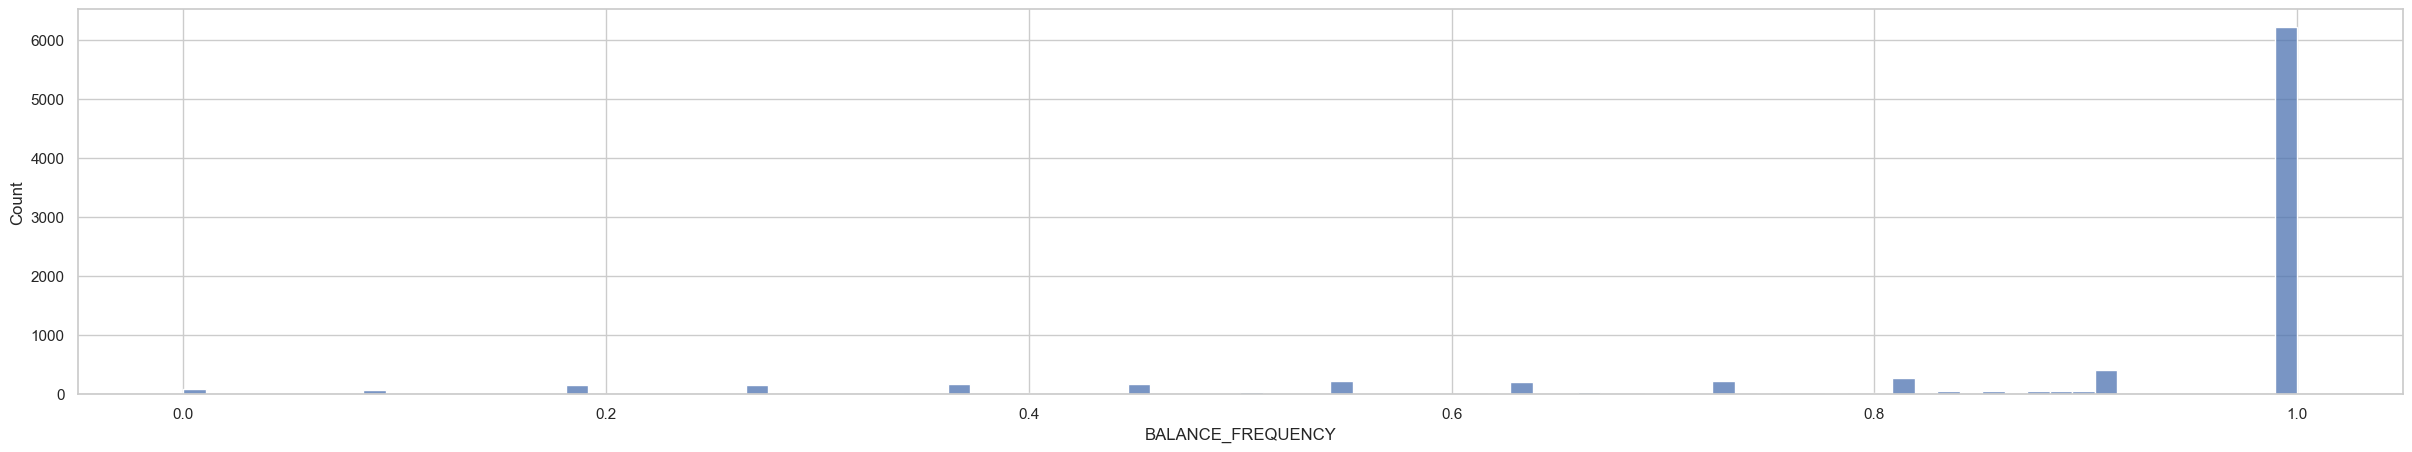

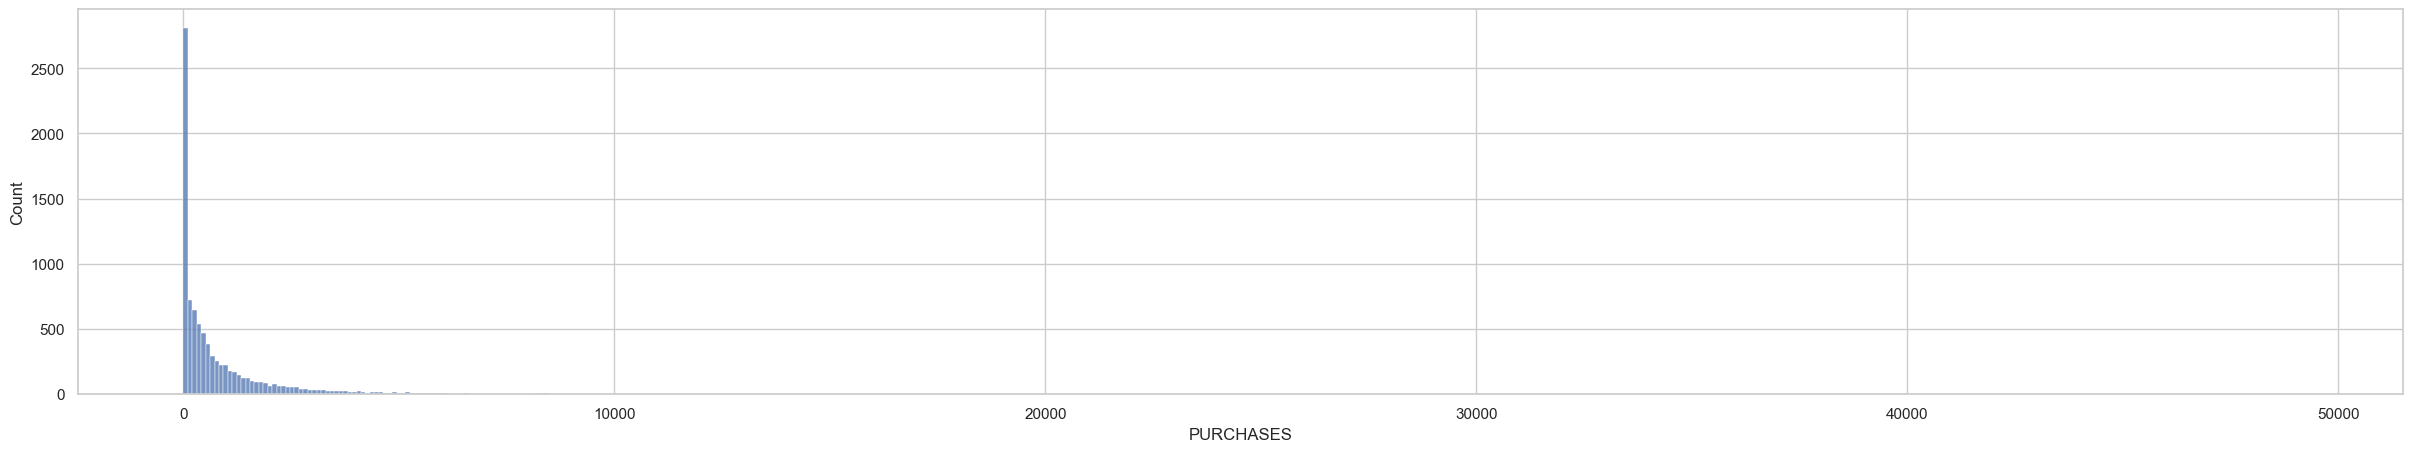

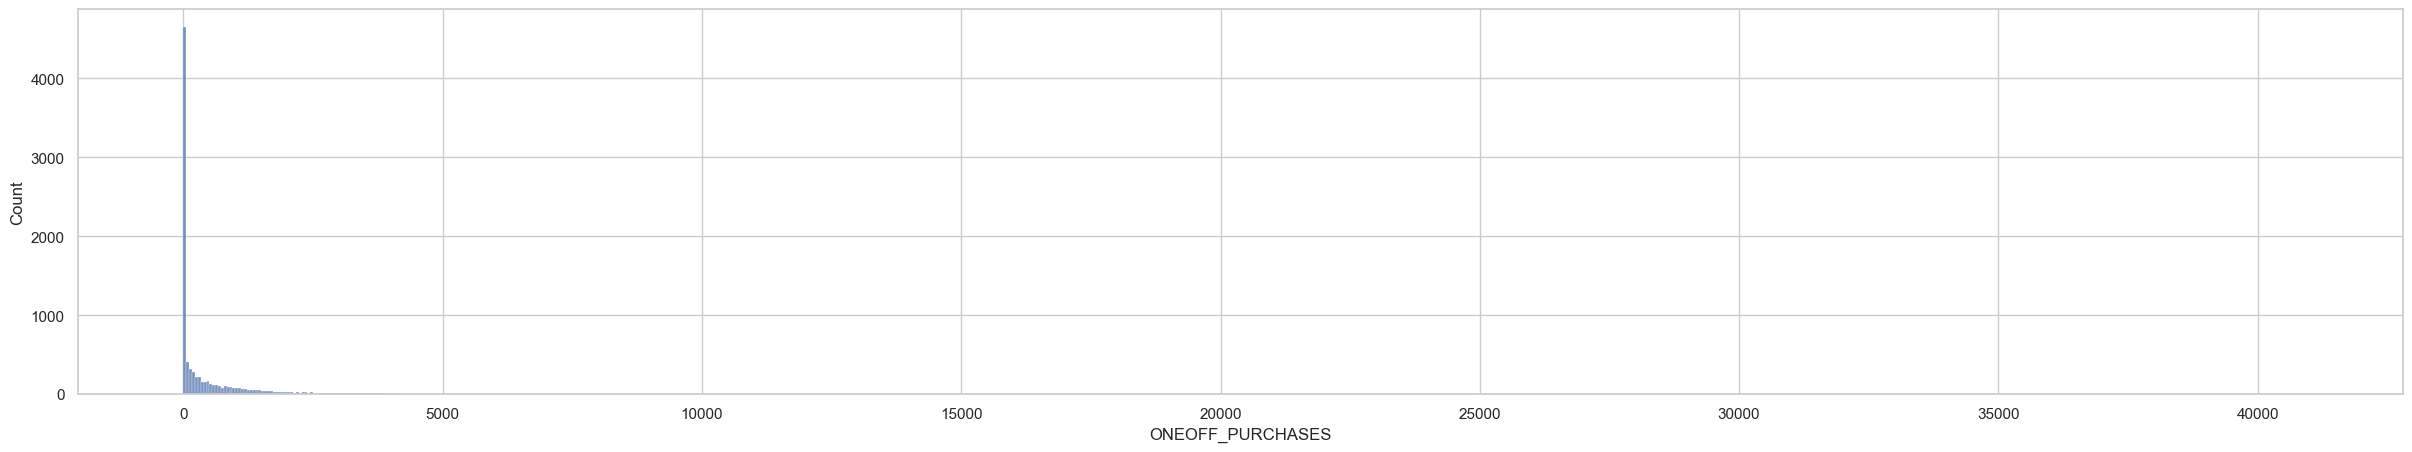

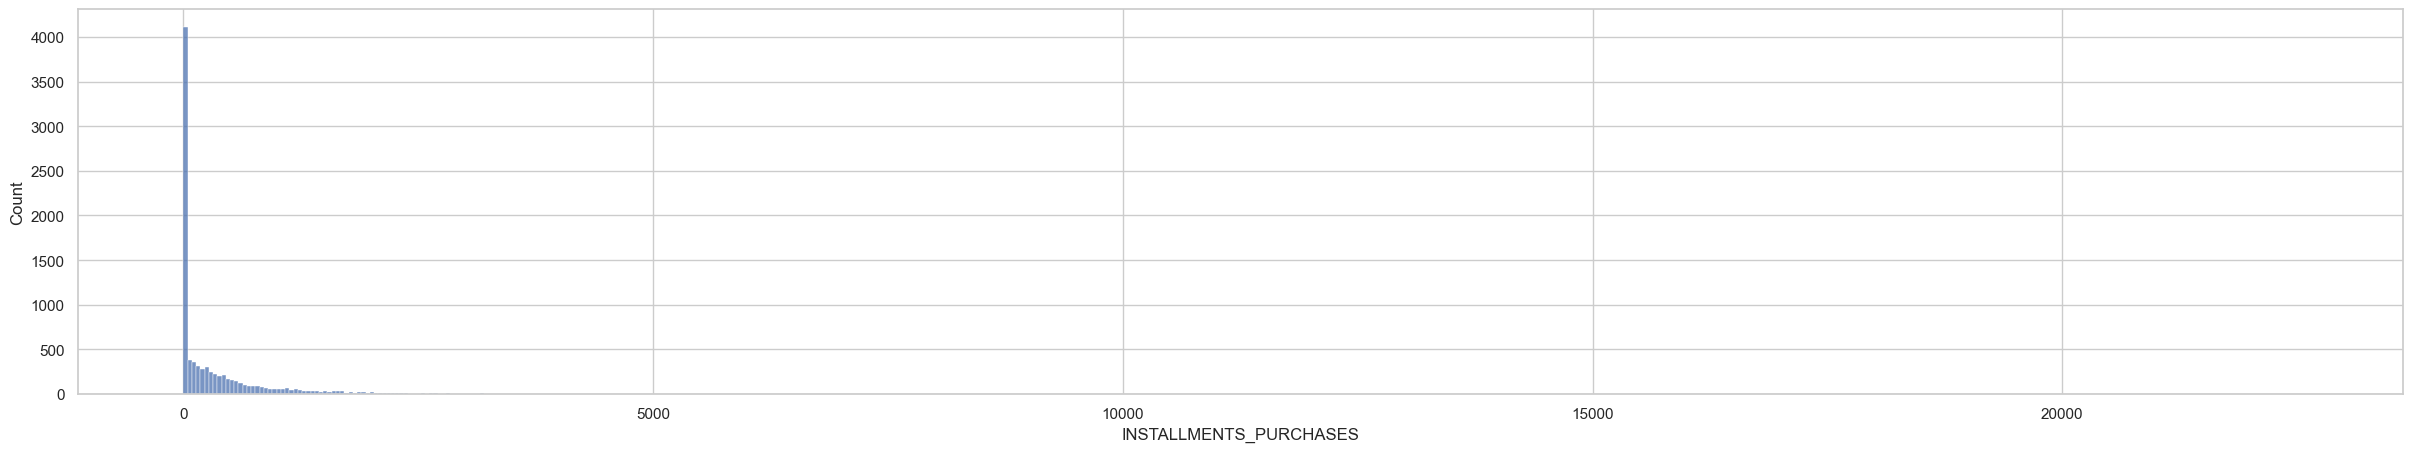

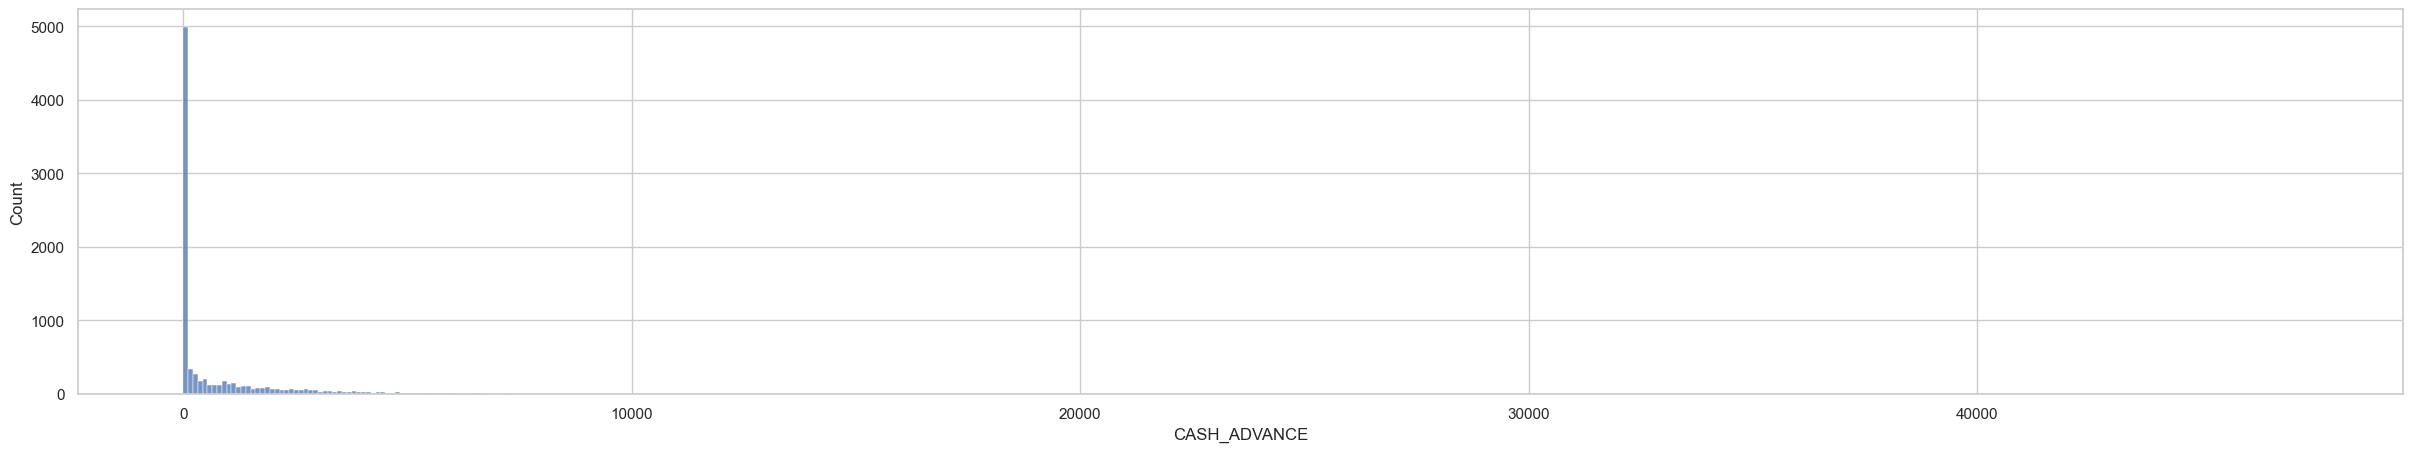

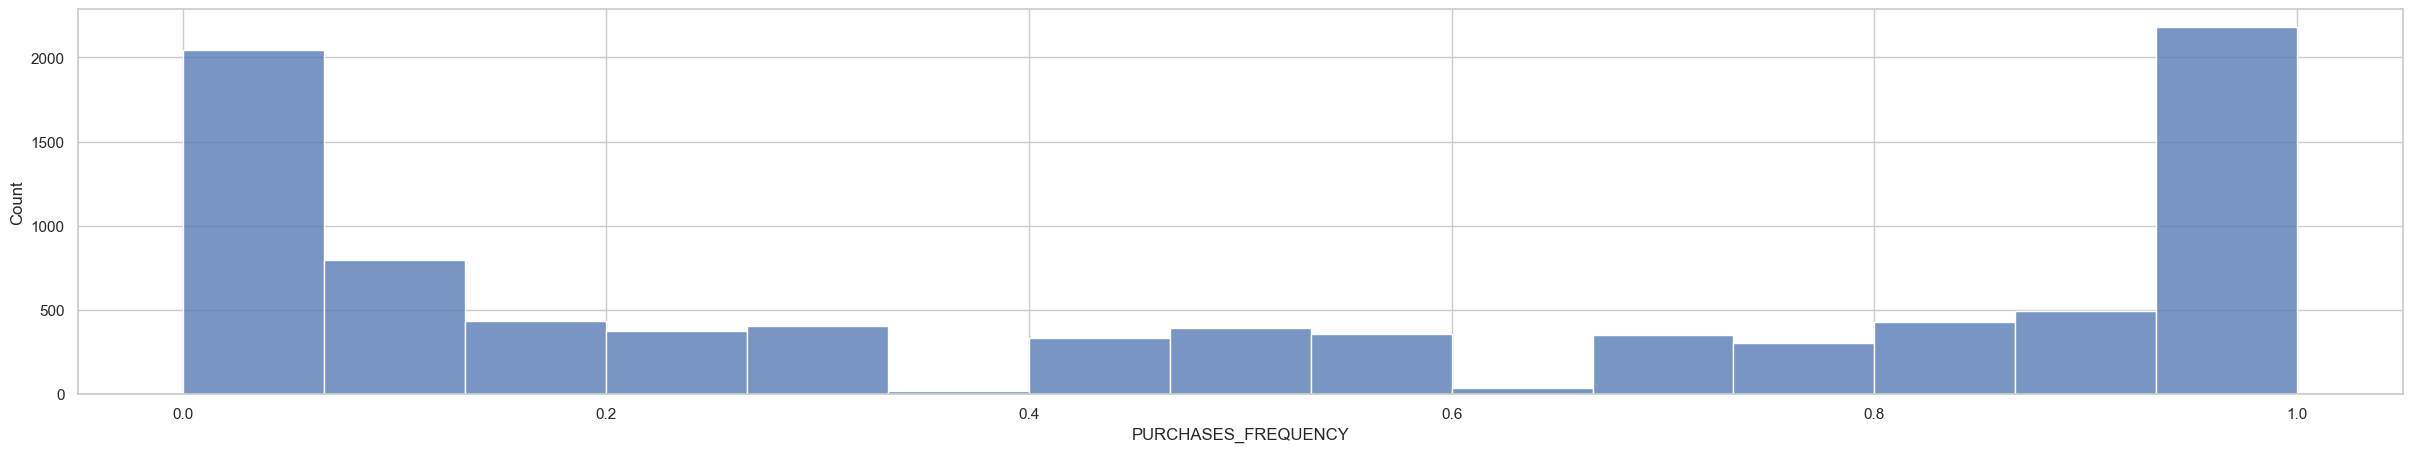

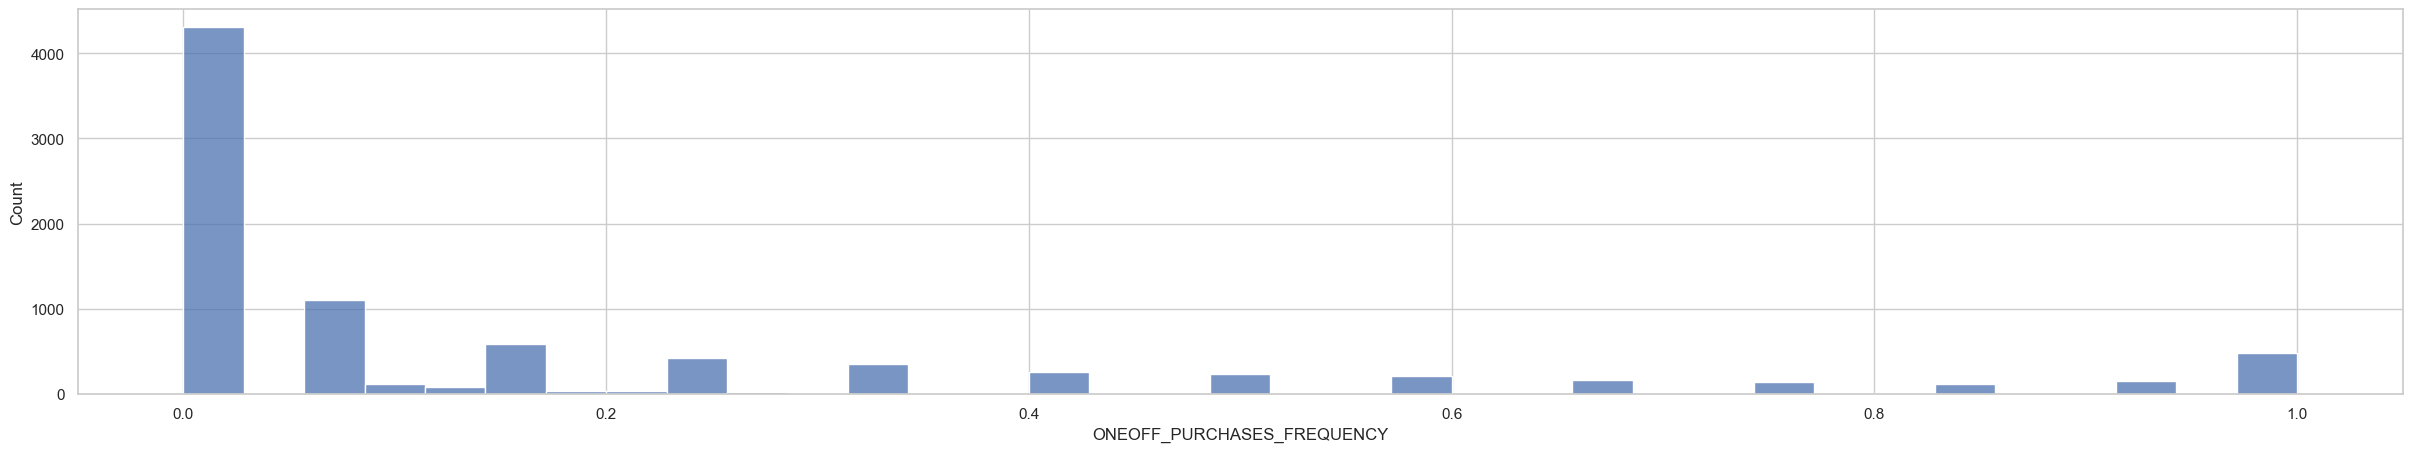

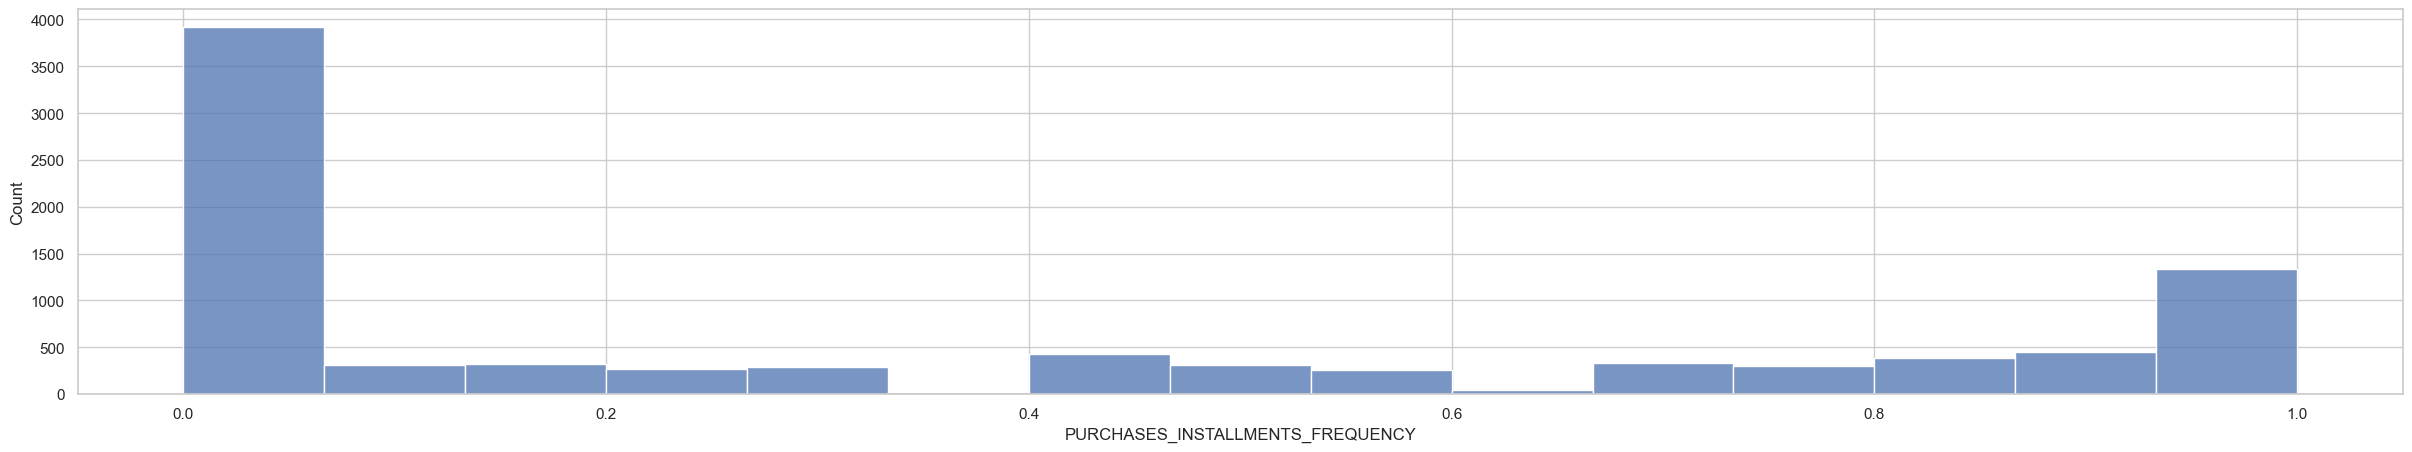

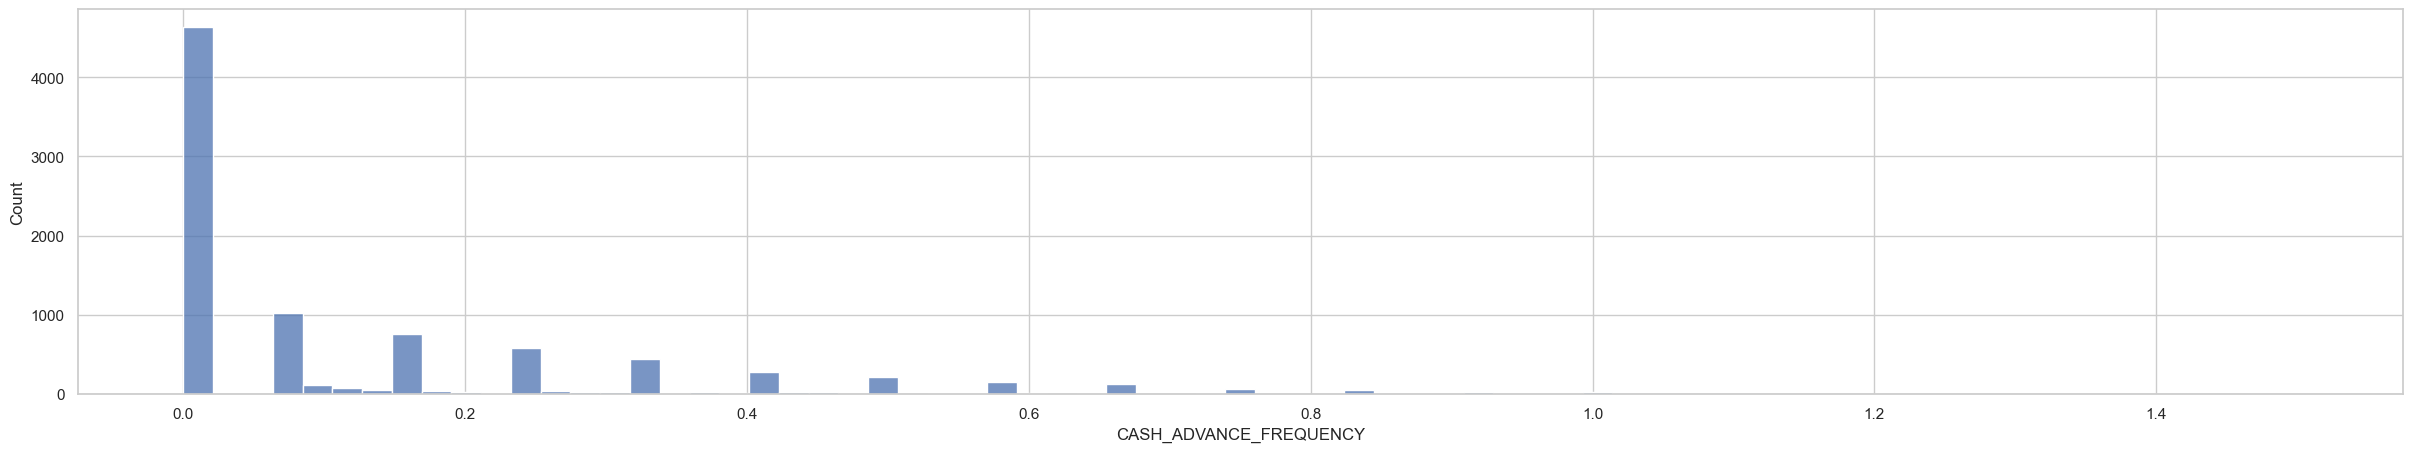

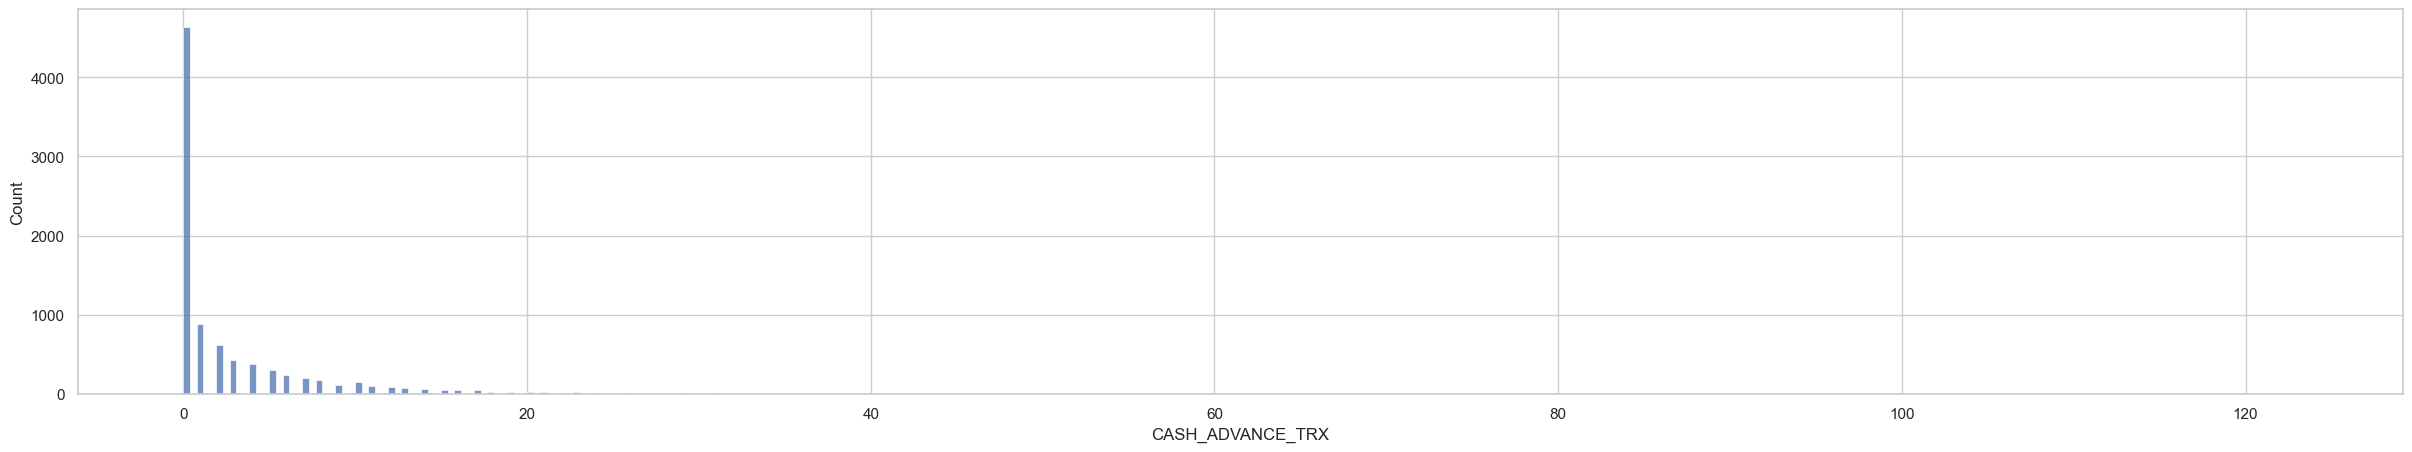

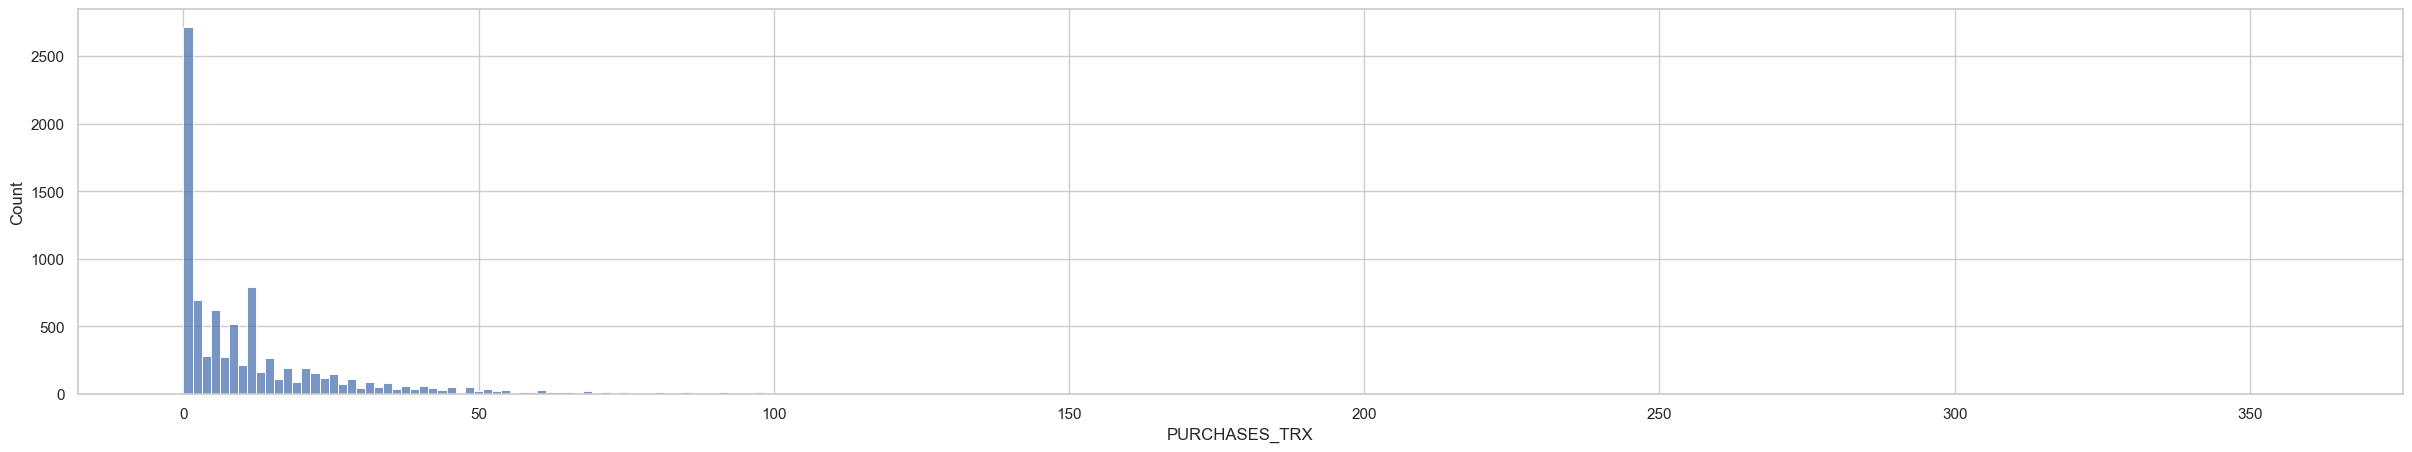

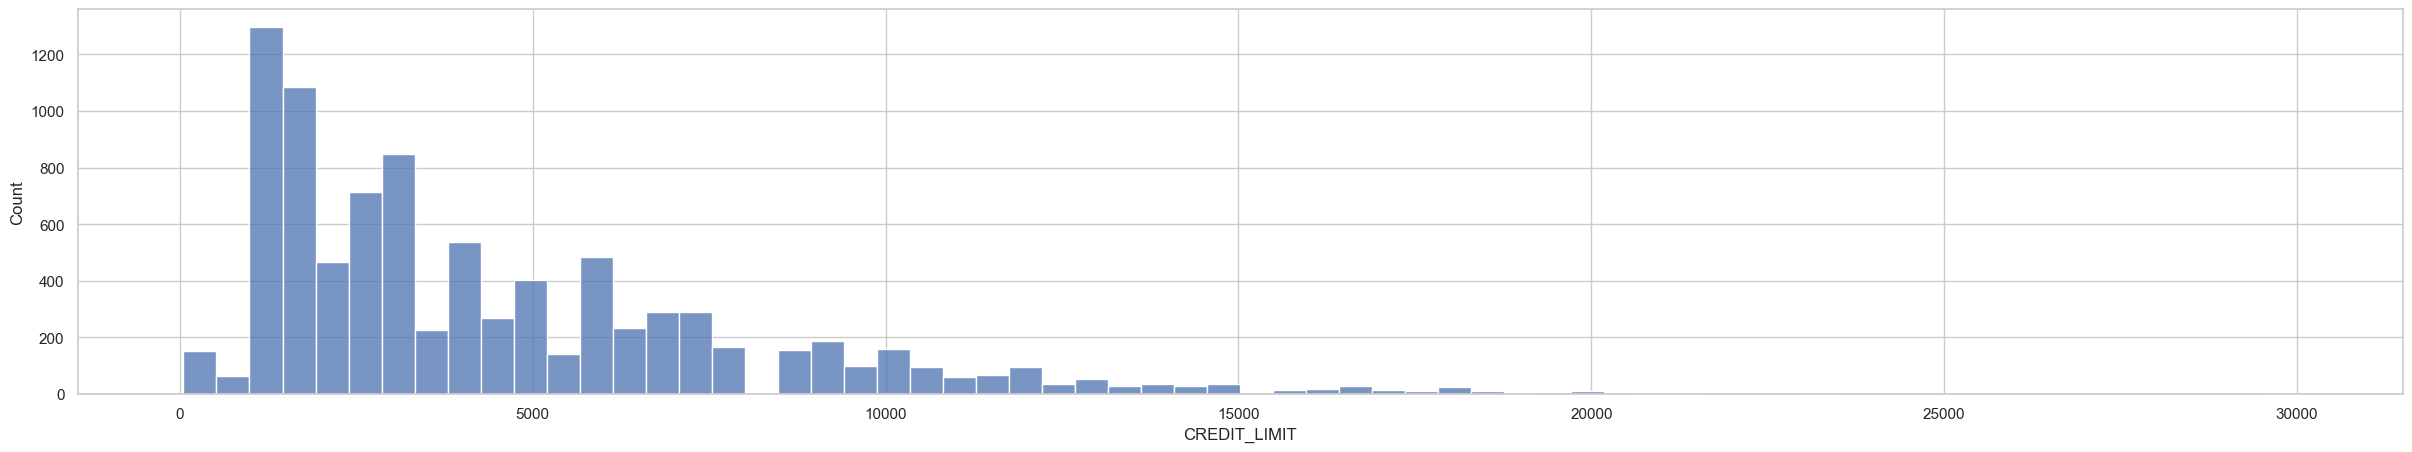

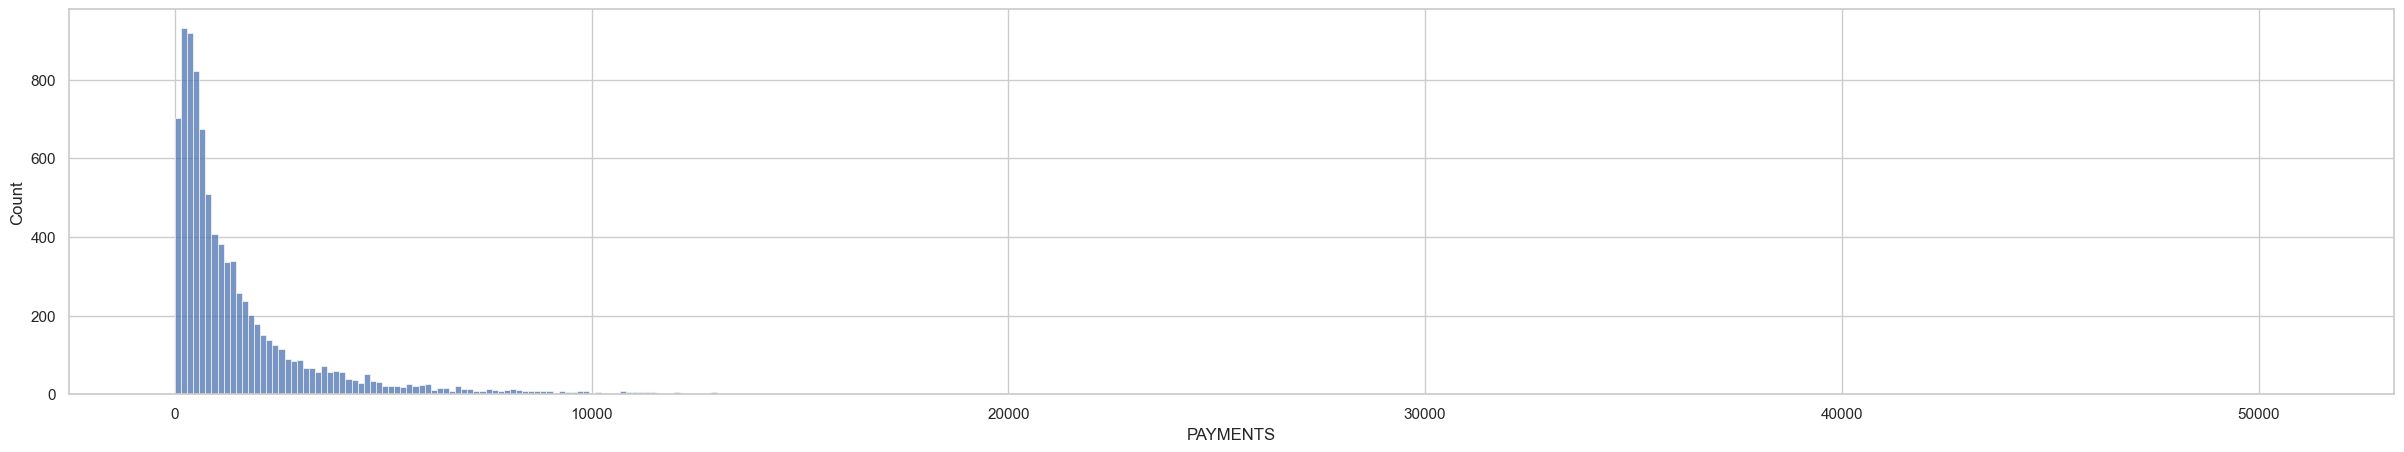

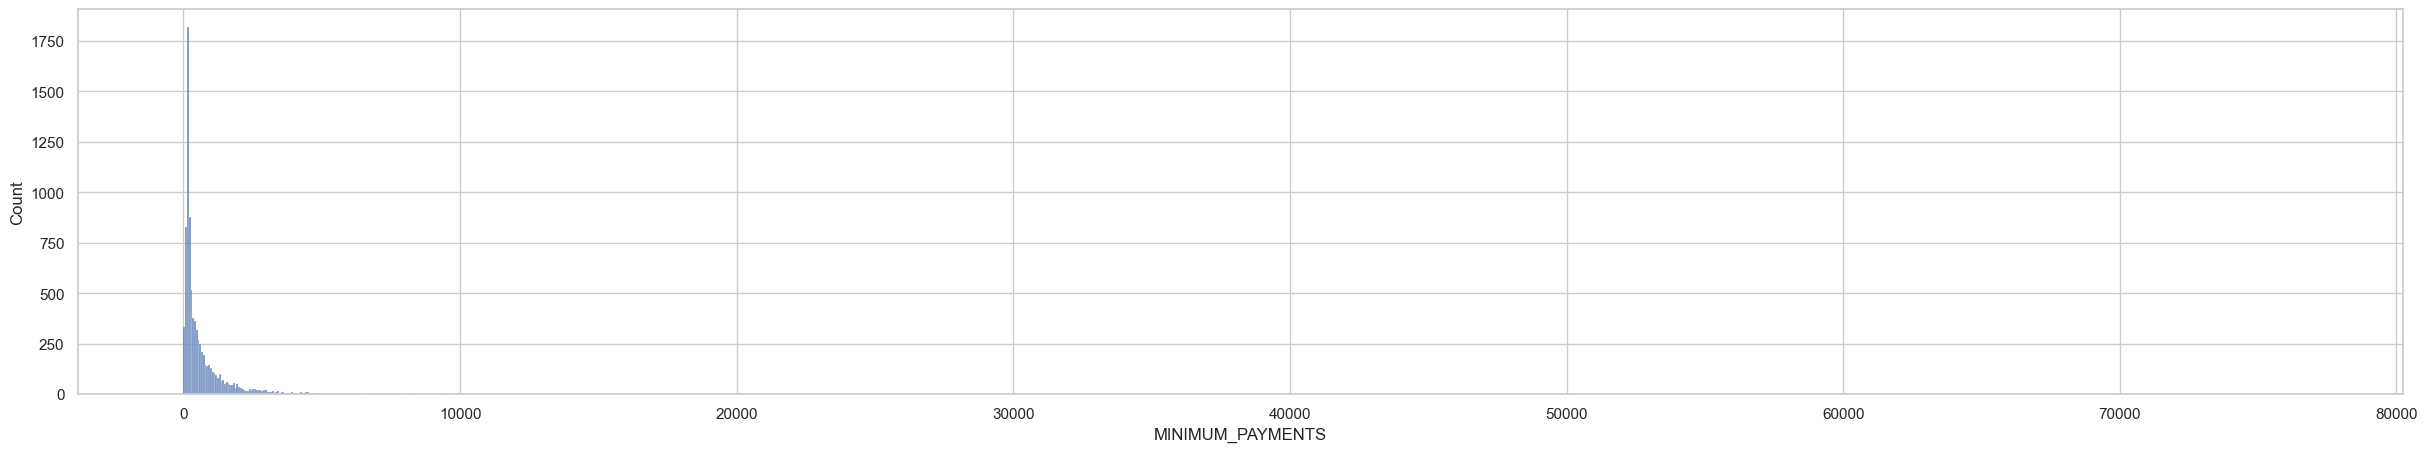

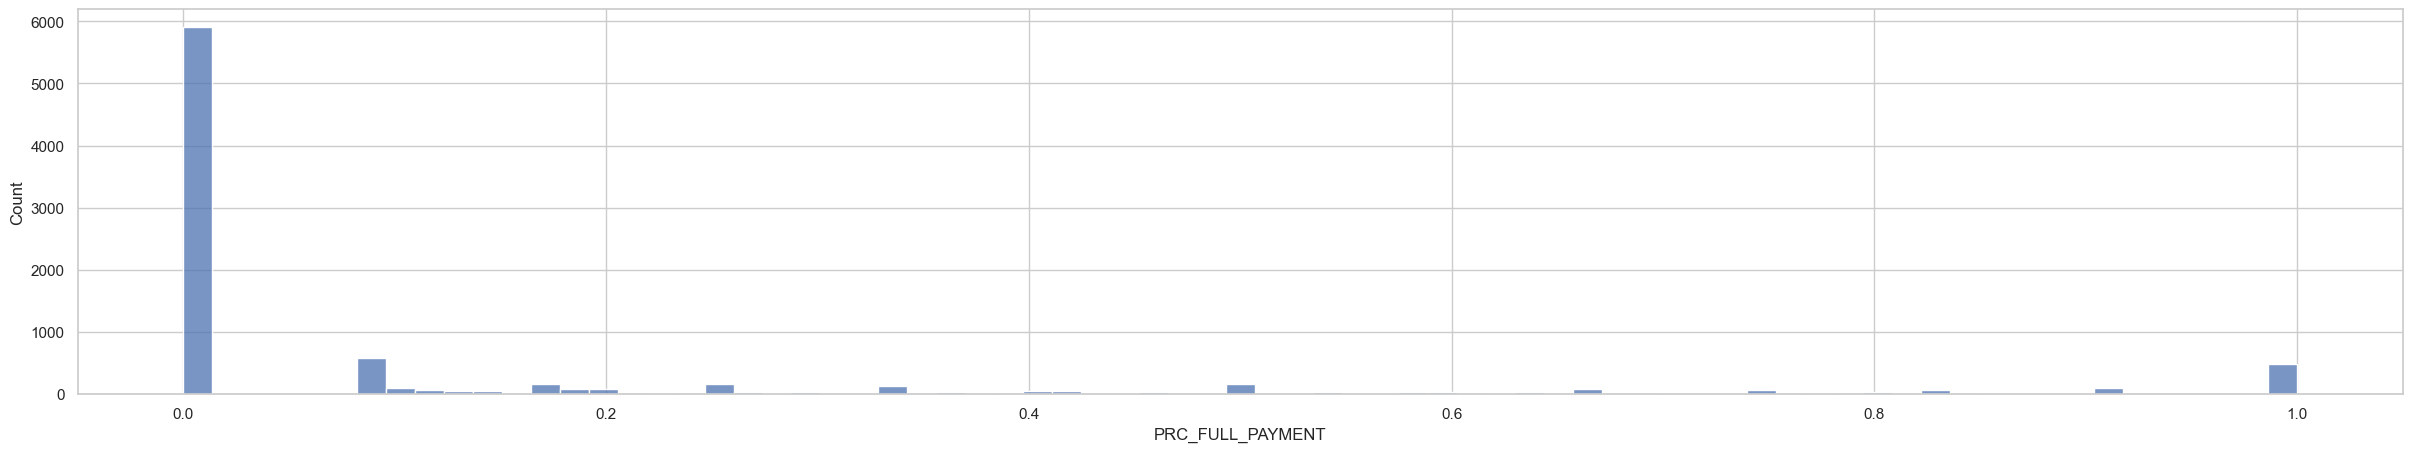

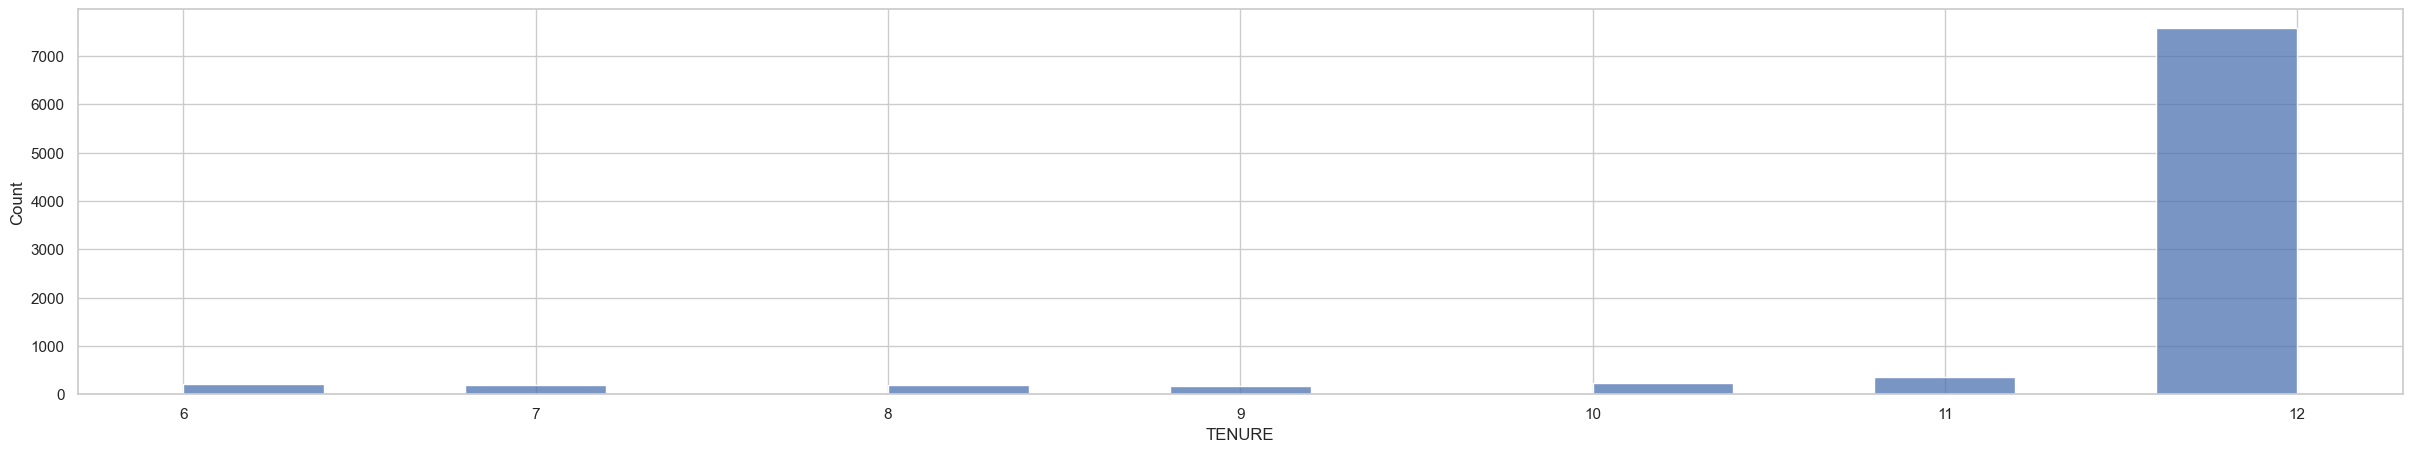

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
for column in df.columns:
    plt.figure(figsize = (30,5))
    sns.histplot(df[column])
    plt.show()

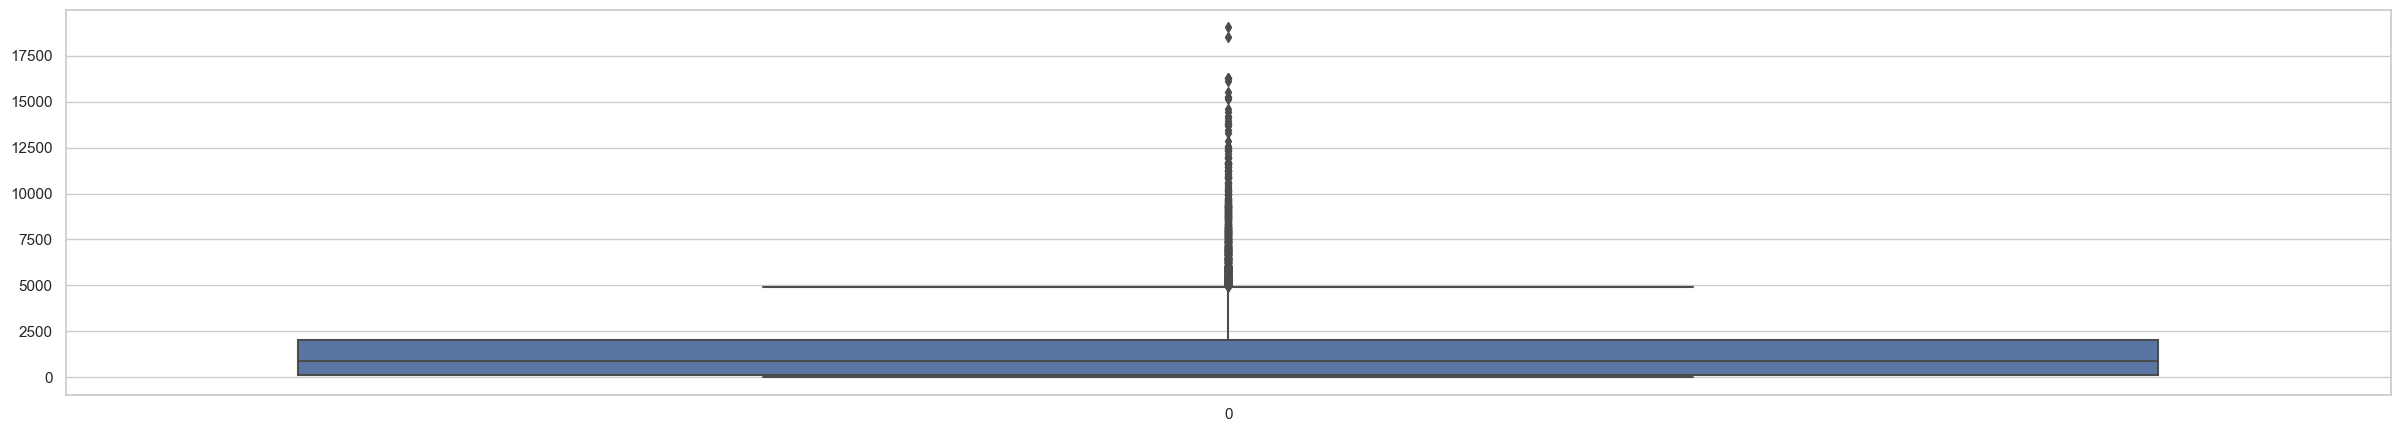

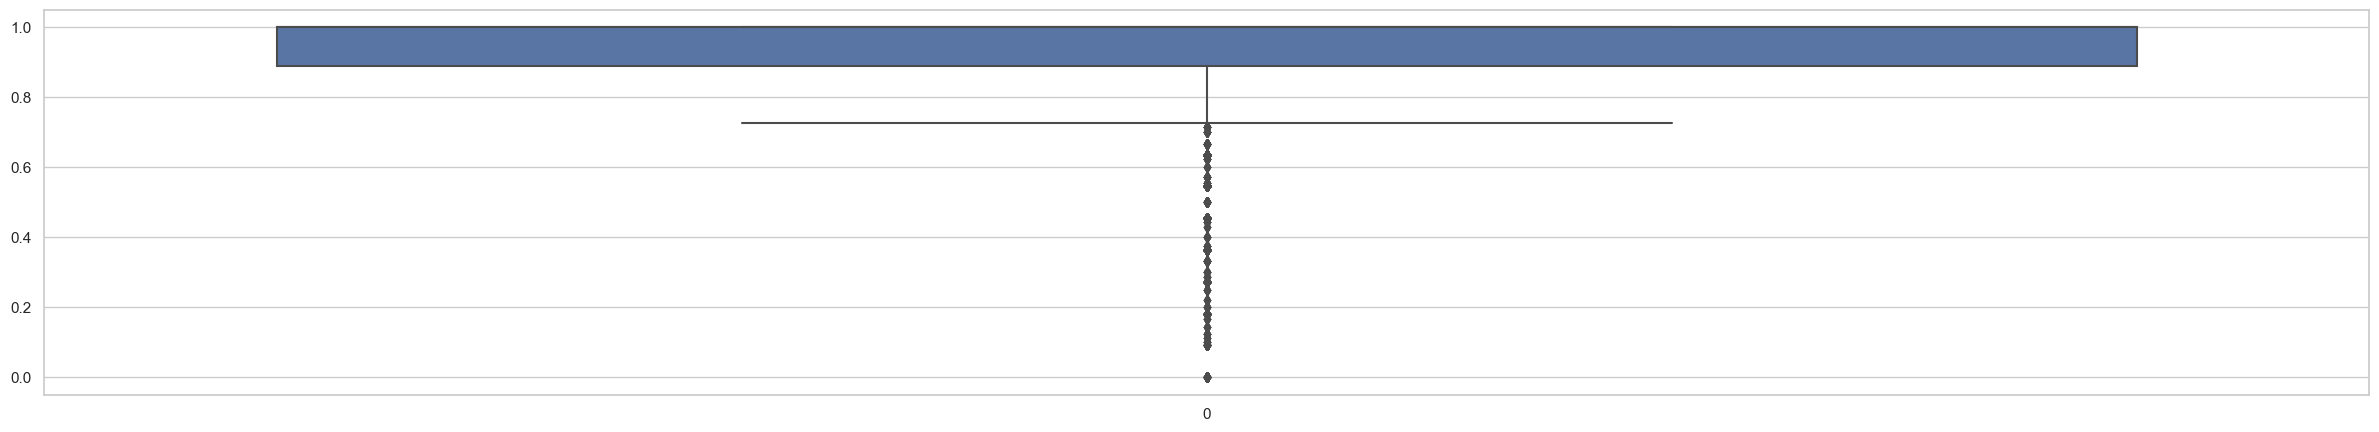

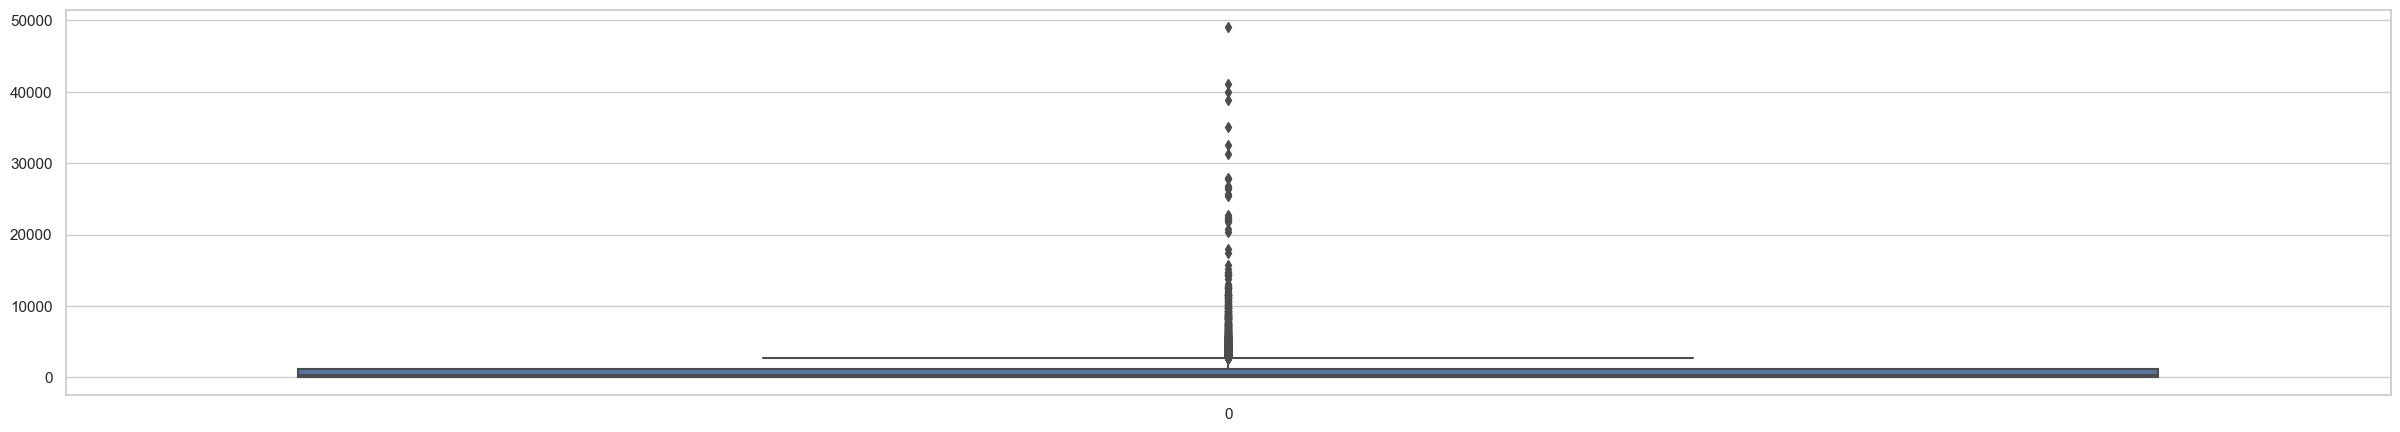

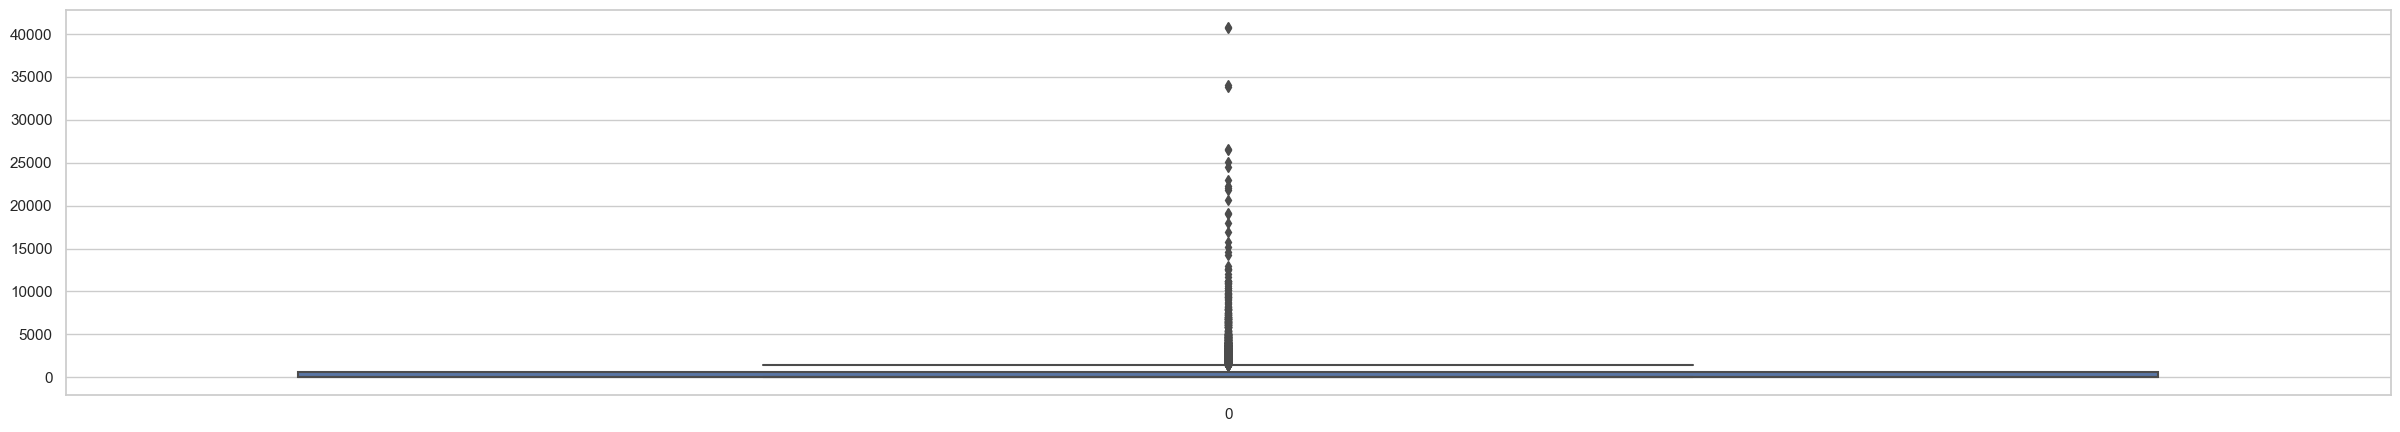

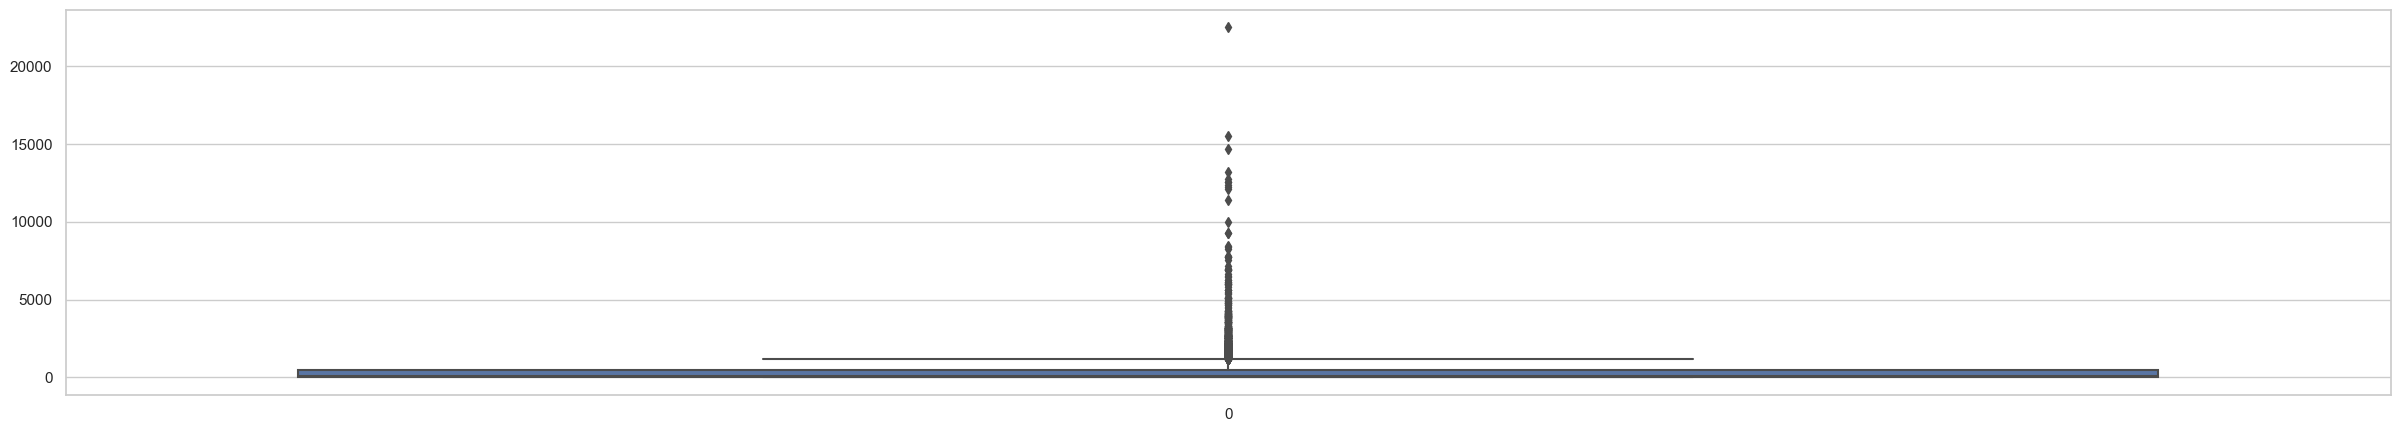

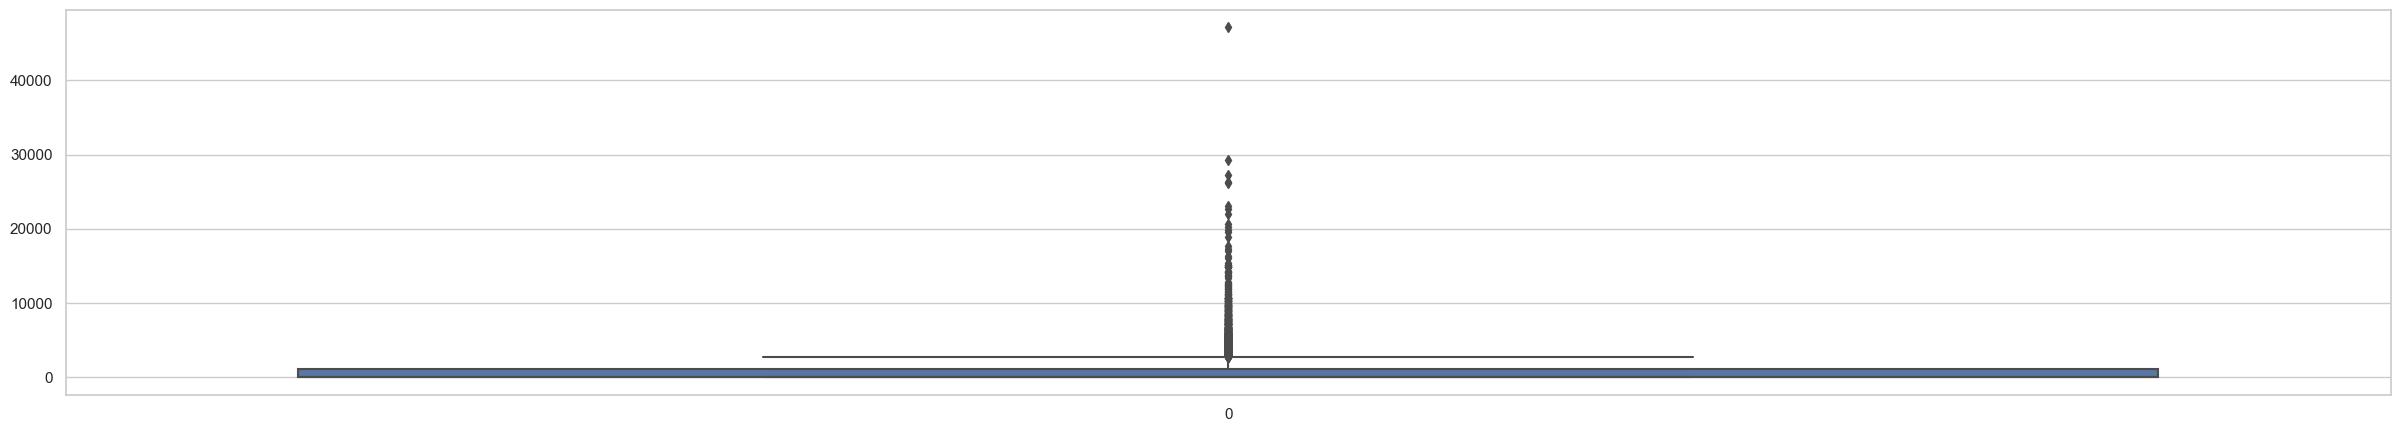

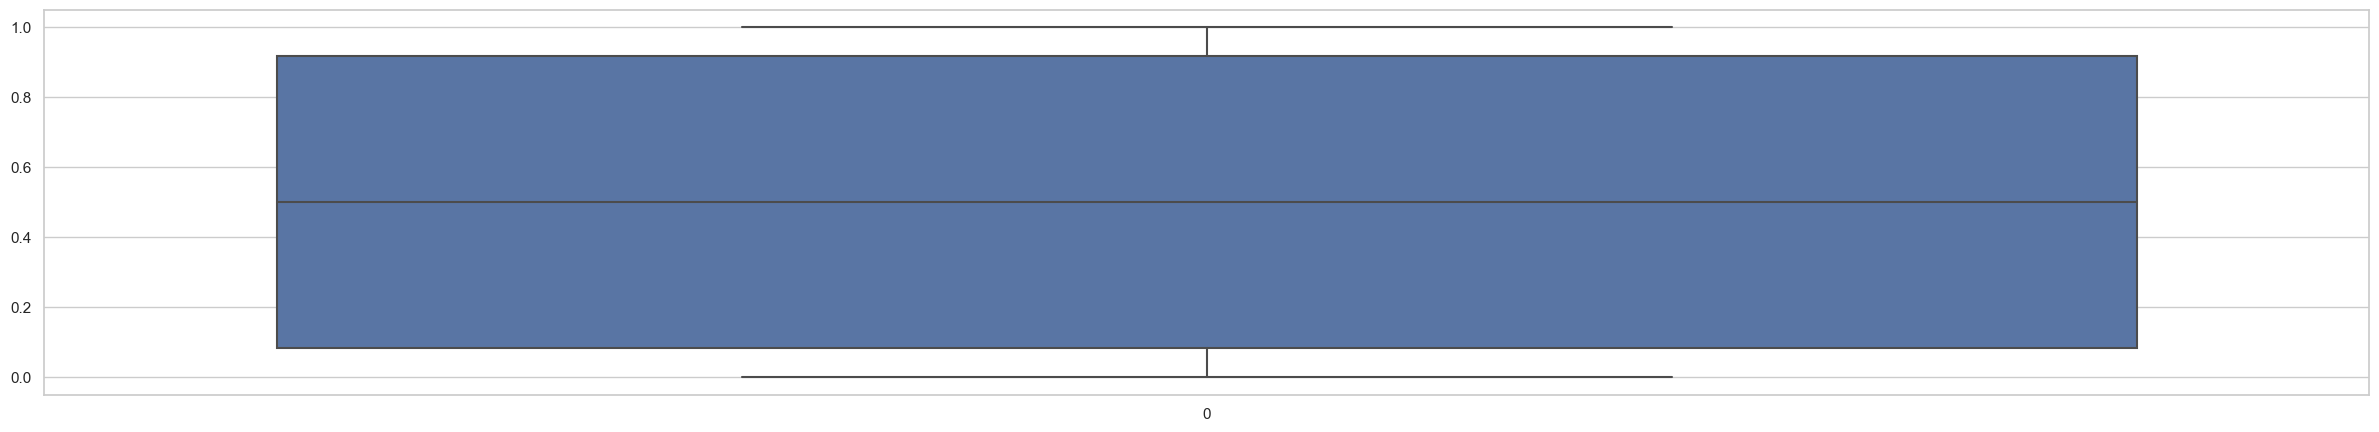

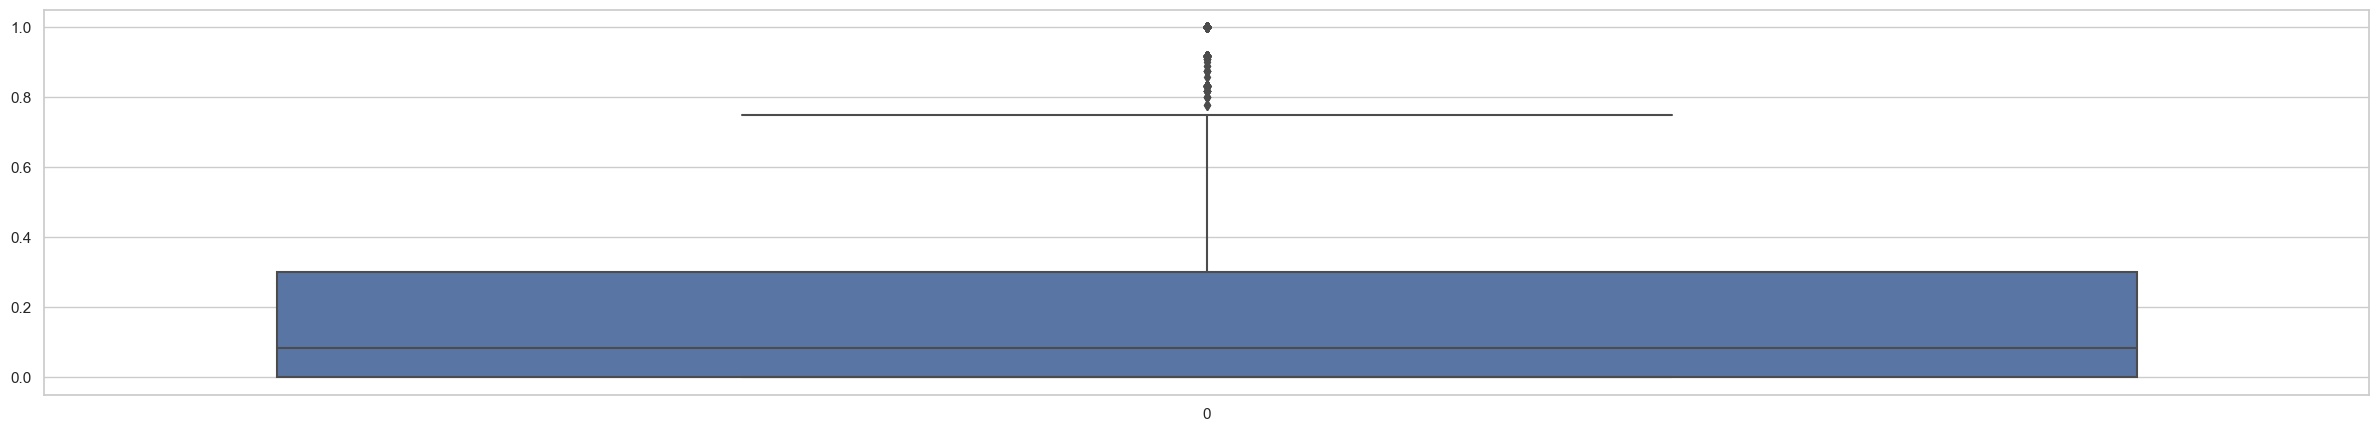

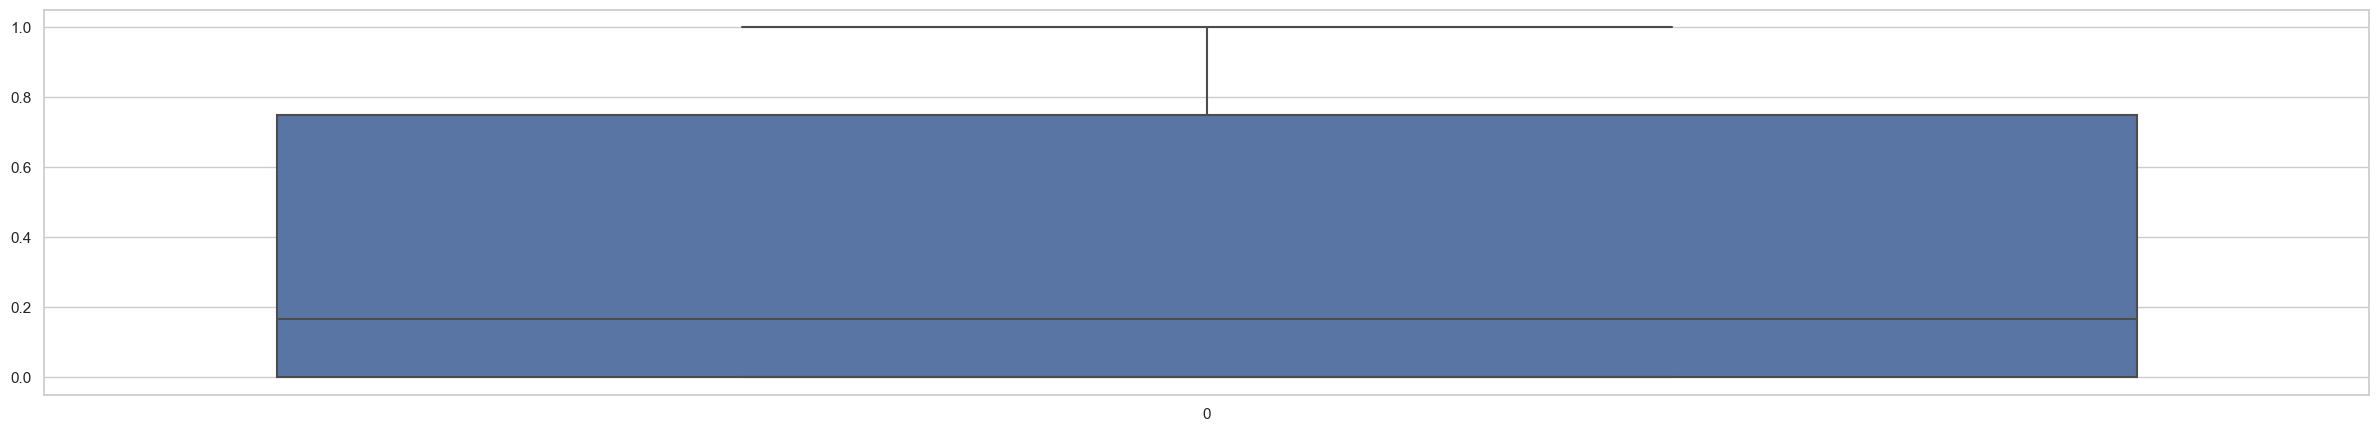

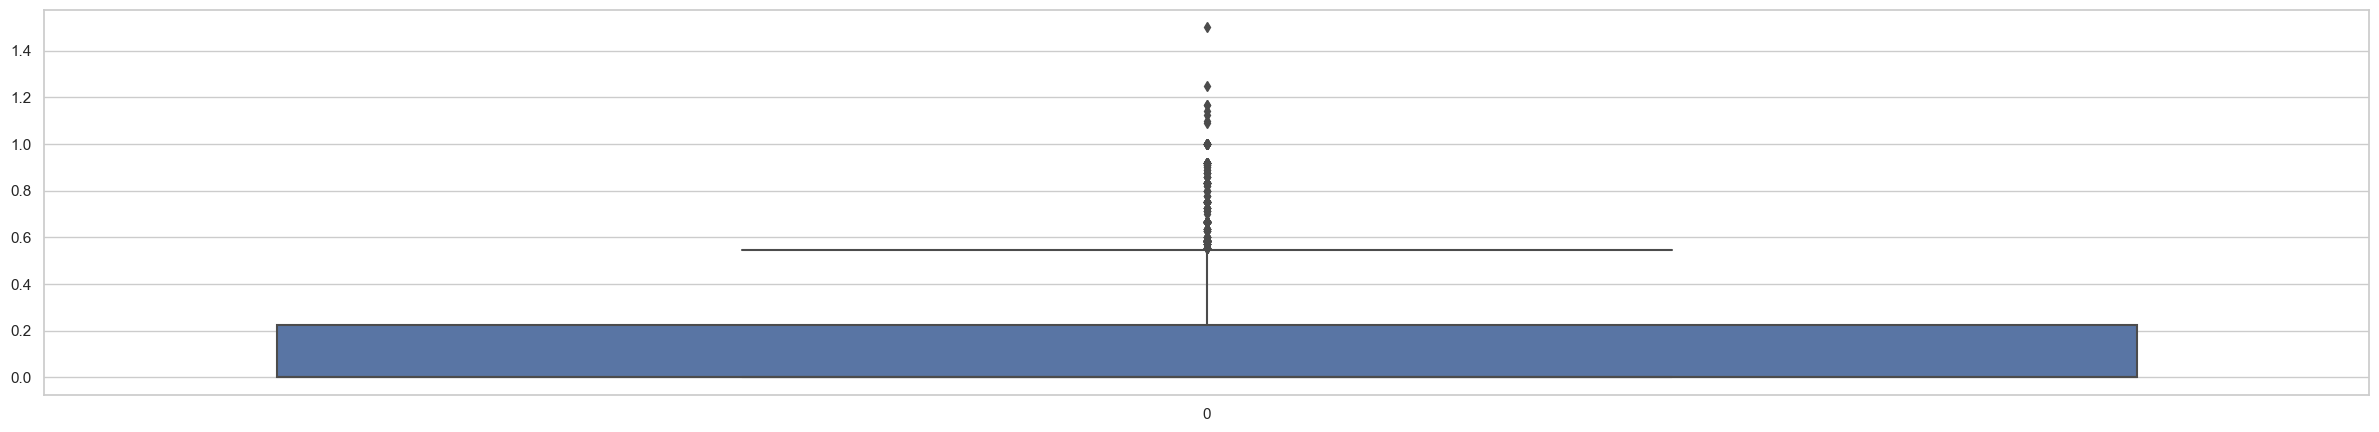

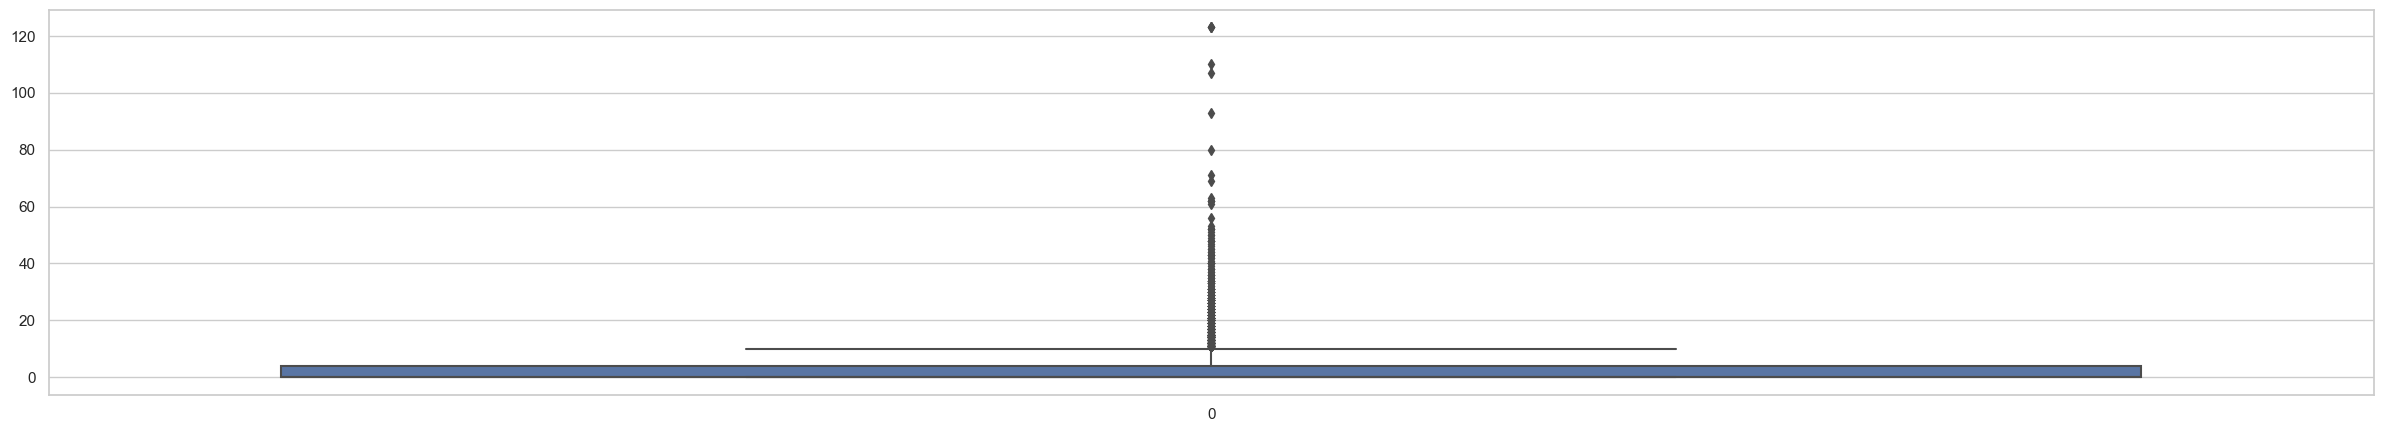

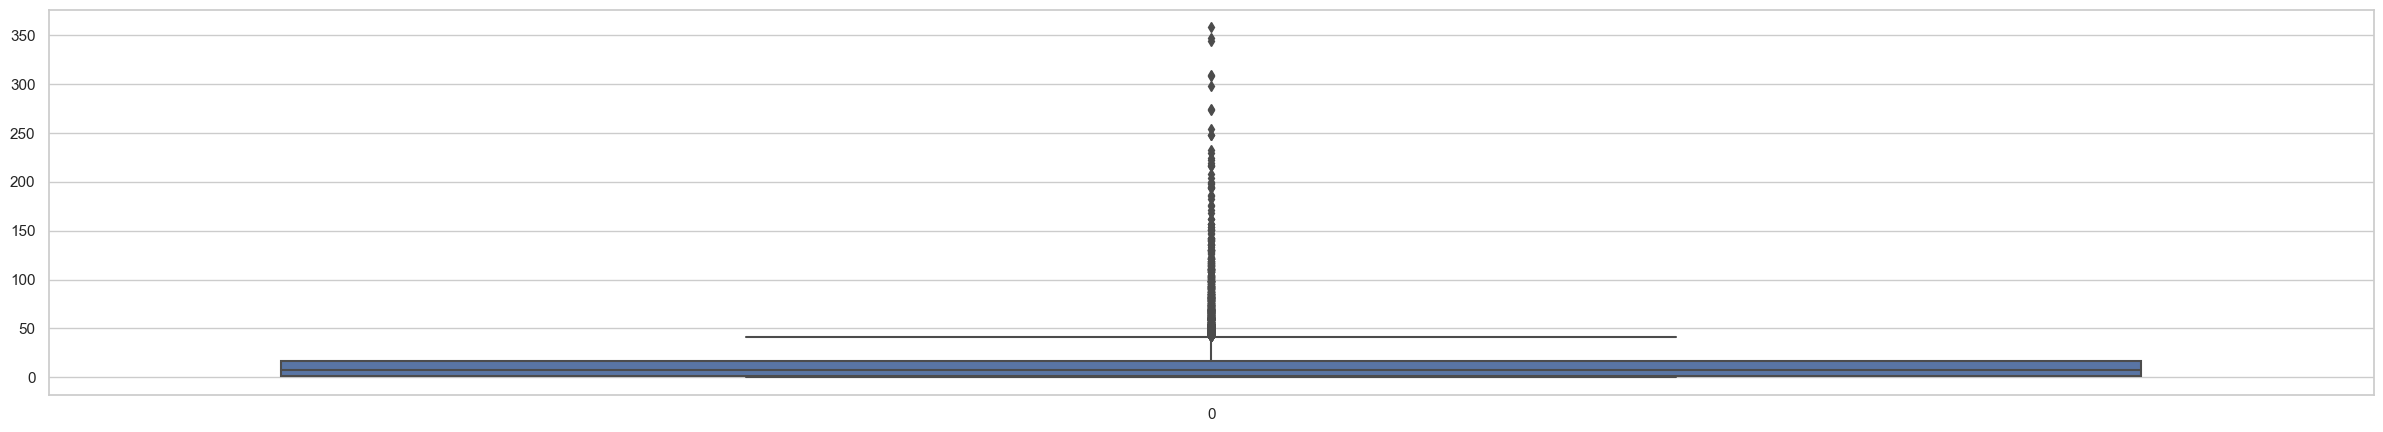

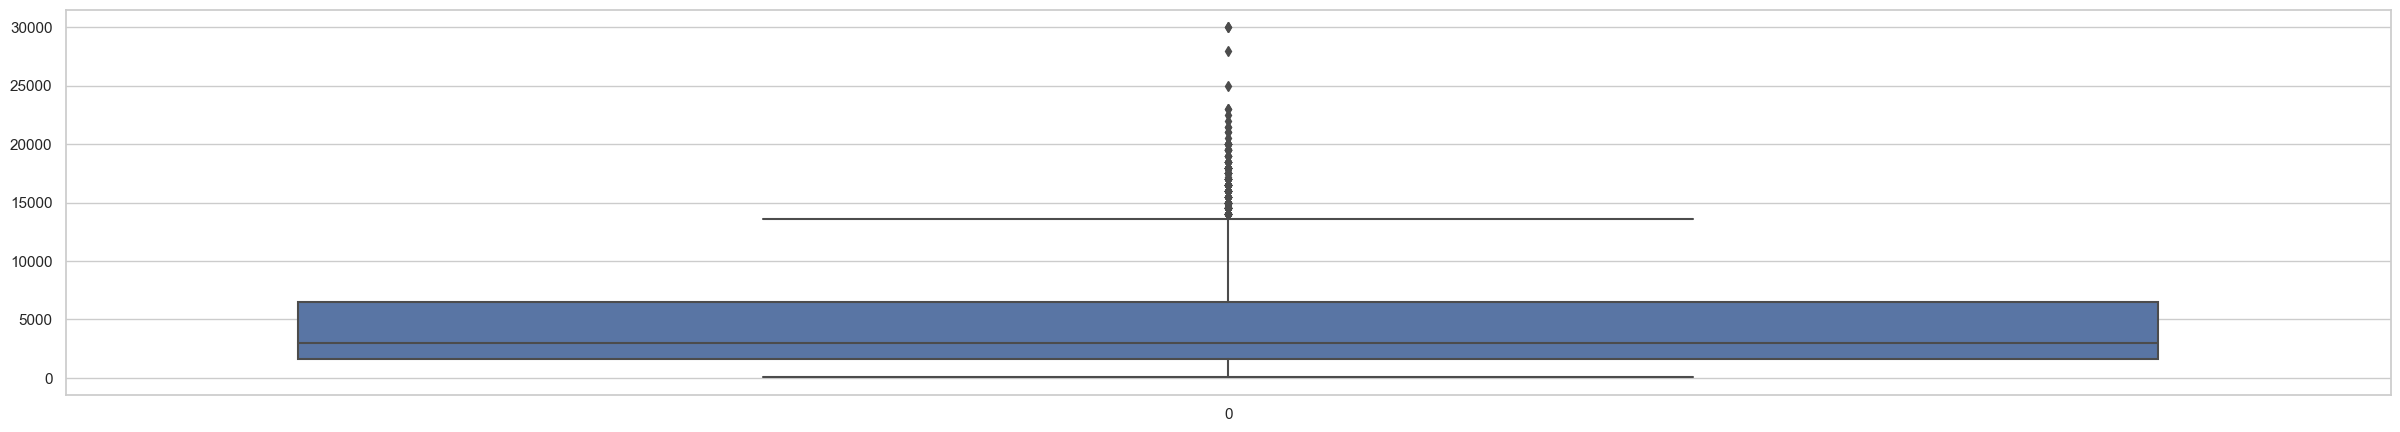

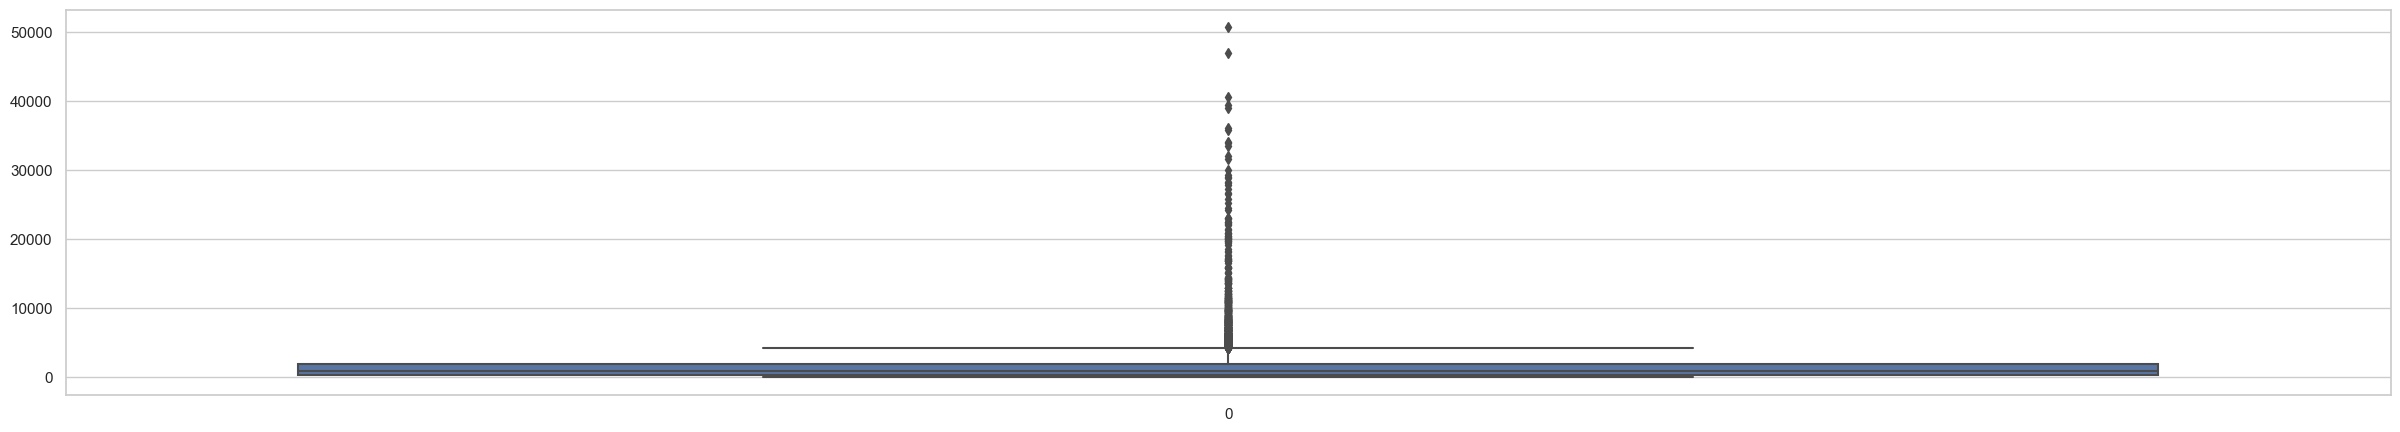

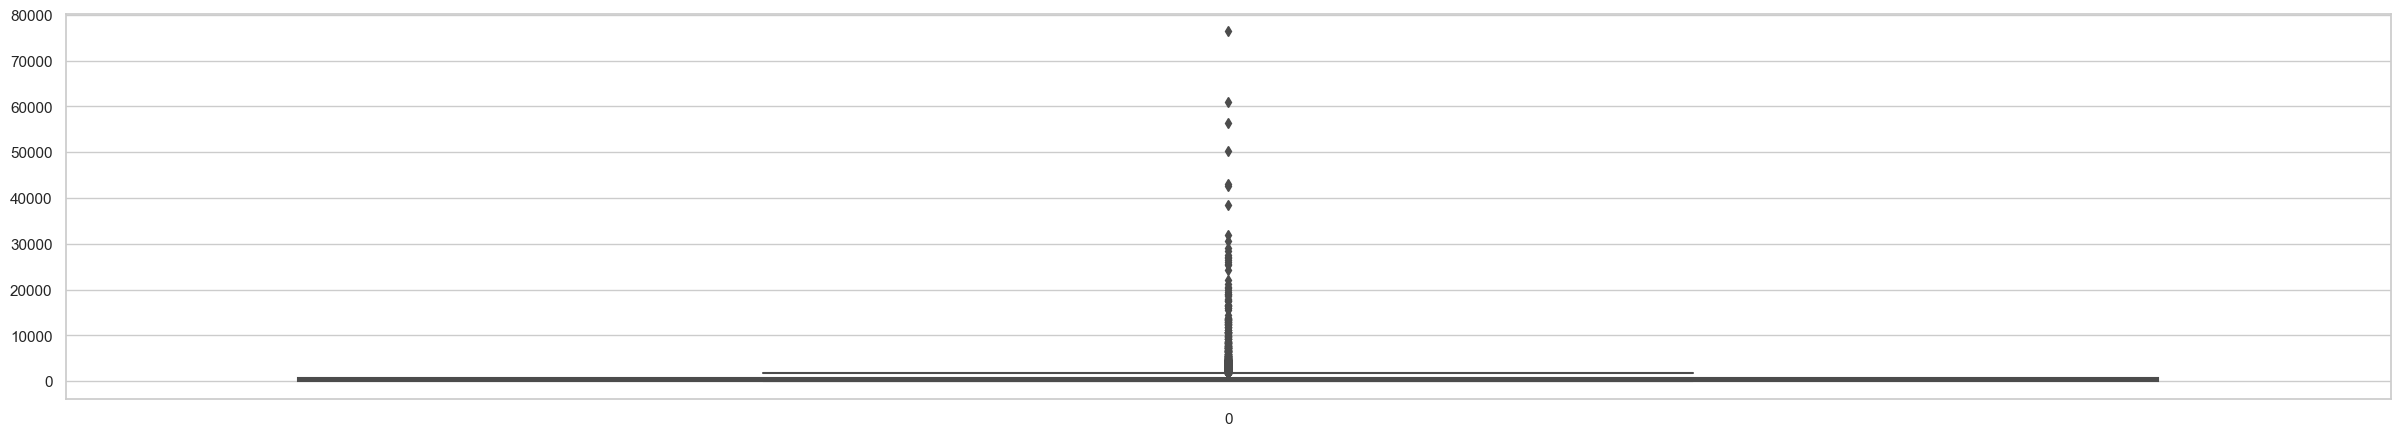

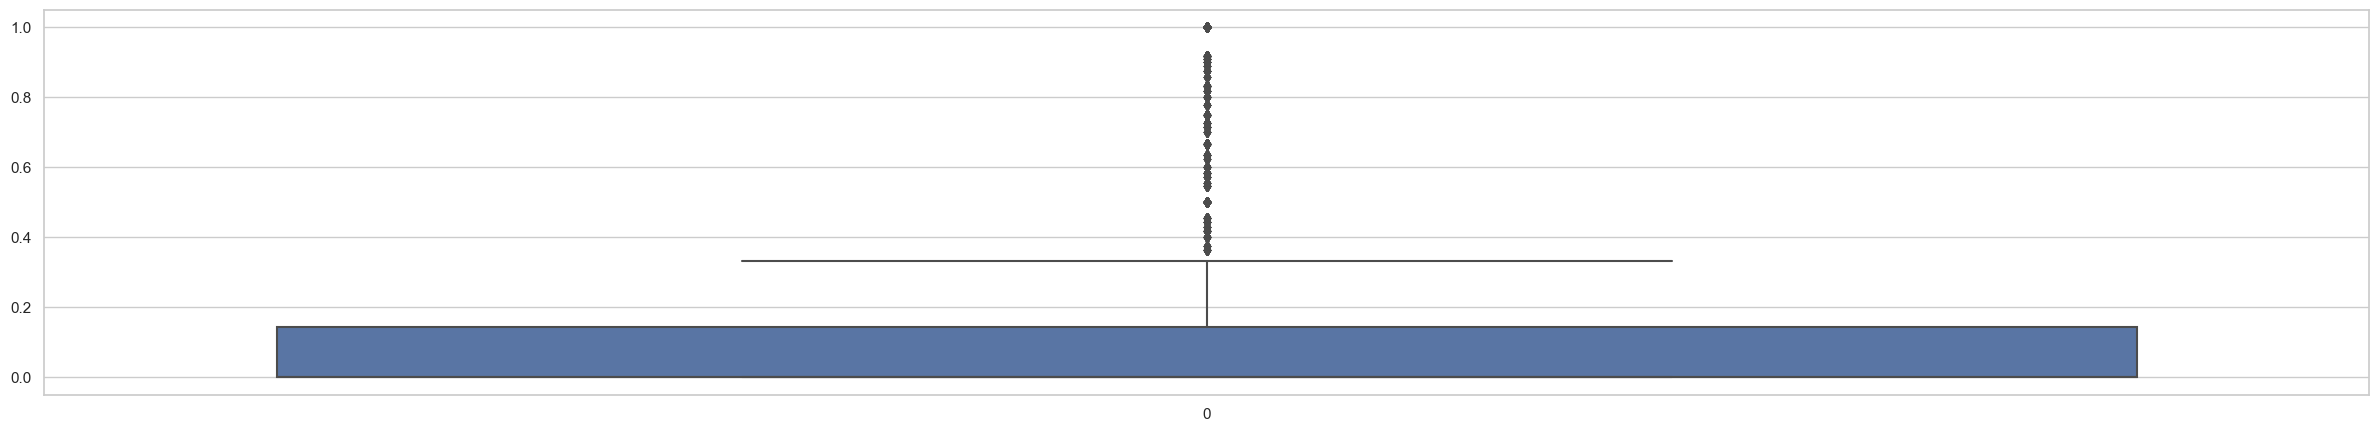

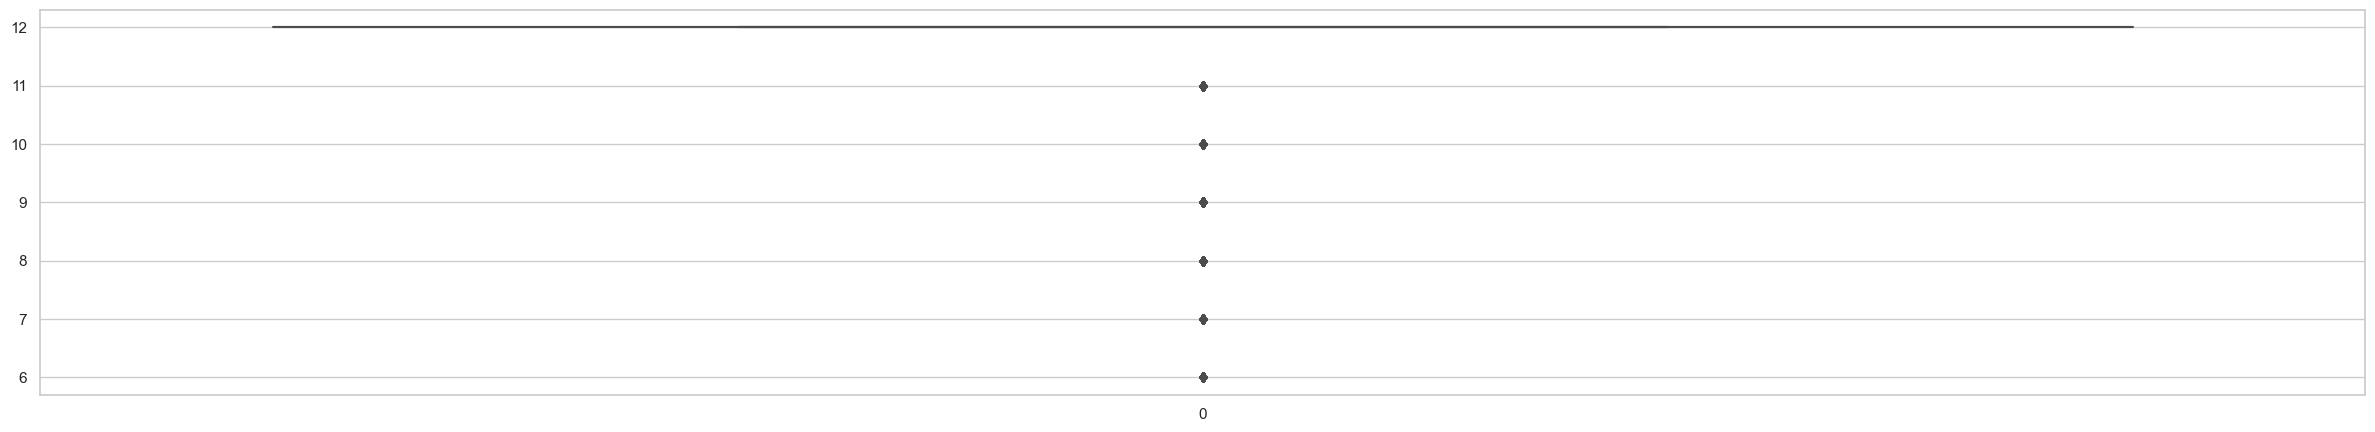

In [26]:
for column in df.columns:
    plt.figure(figsize = (30,5))
    sns.boxplot(df[column])
    plt.show()

In [27]:
#imputing with median values using sklearn.impute
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

X = df['MINIMUM_PAYMENTS'].values.reshape(-1,1)
X = imputer.fit_transform(X) 

df['MINIMUM_PAYMENTS_NEW'] = X
X2 = df['CREDIT_LIMIT'].values.reshape(-1,1)
X2 = imputer.fit_transform(X2) 
df['CREDIT_LIMIT_NEW'] = X2
df = df.drop(['CREDIT_LIMIT','MINIMUM_PAYMENTS'],axis = 1)


In [28]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd

# Function to handle missing values
def missing_value_treatment(df):
    df = df.copy()
    missing_columns = df.columns[df.isna().any()].tolist()
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_cols = list(set(df.columns) - set(numerical_cols))
    
    for col in missing_columns:
        missing_ratio = df[col].isna().sum() / len(df)
        if missing_ratio <= 0.05 and len(df) > 30000:
            df.dropna(subset=[col], inplace=True)
        elif missing_ratio > 0.8:
            df.drop(columns=[col], inplace=True)
        else:
            if col in categorical_cols:
                mode_val = df[col].mode()[0]
                df[col].fillna(mode_val, inplace=True)
            else:
                imputer = IterativeImputer(max_iter=10, random_state=0)
                imputed_data = imputer.fit_transform(df[numerical_cols])
                df[numerical_cols] = pd.DataFrame(imputed_data, columns=numerical_cols)

    df.reset_index(drop=True, inplace=True)
    print("Missing values treated successfully.")
    return df

# Function to handle duplicate values
def duplicate_value_treatment(df):
    df = df.copy()
    initial_count = len(df)
    df.drop_duplicates(inplace=True)
    final_count = len(df)
    df.reset_index(drop=True, inplace=True)
    print(f"Duplicate values removed: {initial_count - final_count}")
    return df

# Function to standardize numerical columns
def data_standardization(df, scaling_type=1):
    df = df.copy()
    num_var = [col for col in df.columns if df[col].dtype in ['float64', 'int64']]
    
    if scaling_type == 1:
        scaler = StandardScaler()
    elif scaling_type == 2:
        scaler = MinMaxScaler()
    else:
        print("Invalid scaling type. Choose 1 (StandardScaler) or 2 (MinMaxScaler).")
        return df
    
    for col in num_var:
        df[col] = scaler.fit_transform(df[[col]]).round(2)
    
    print(f"Data standardized using {'StandardScaler' if scaling_type == 1 else 'MinMaxScaler'}.")
    return df

# Function to encode categorical columns
def cat_encoding(df):
    df = df.copy()
    cat_var = [col for col in df.columns if df[col].dtype in ['object', 'category']]
    label_encoder = LabelEncoder()
    
    for col in cat_var:
        df[col] = label_encoder.fit_transform(df[col].astype(str))
    
    print("Categorical variables encoded successfully.")
    return df

# Main data preprocessing pipeline
def preprocess_data(df, scaling_type=1):
    print("Starting data preprocessing...")
    df = missing_value_treatment(df)
    df = duplicate_value_treatment(df)
    df = data_standardization(df, scaling_type)
    df = cat_encoding(df)
    print("Data preprocessing completed.")
    return df

# Example Usage:
df = preprocess_data(df, scaling_type=1)


Starting data preprocessing...
Missing values treated successfully.
Duplicate values removed: 0
Data standardized using StandardScaler.
Categorical variables encoded successfully.
Data preprocessing completed.


In [29]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import pandas as pd

def data_standardization(df, scaling_type=1):
    df = df.copy()
    num_var = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]
    if scaling_type == 1:
        scaler = StandardScaler()
    elif scaling_type == 2:
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid scaling_type. Use 1 for StandardScaler or 2 for MinMaxScaler.")
    df[num_var] = scaler.fit_transform(df[num_var]).round(2)
    return df

def cat_encoding(df):
    df = df.copy()
    cat_var = [col for col in df.columns if pd.api.types.is_categorical_dtype(df[col]) or pd.api.types.is_object_dtype(df[col])]
    label_encoder = LabelEncoder()
    for feature in cat_var:
        df[feature] = label_encoder.fit_transform(df[feature])
    return df

df = cat_encoding(df)
df = data_standardization(df, scaling_type=2)

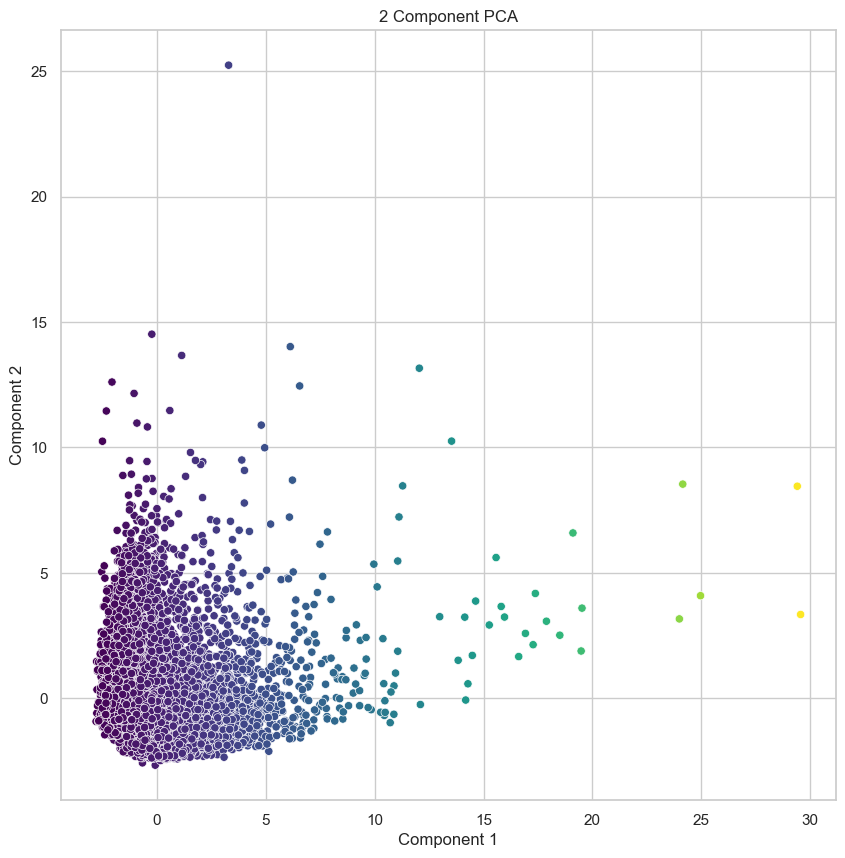

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8950 samples in 0.002s...
[t-SNE] Computed neighbors for 8950 samples in 0.859s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8950
[t-SNE] Computed conditional probabilities for sample 2000 / 8950
[t-SNE] Computed conditional probabilities for sample 3000 / 8950
[t-SNE] Computed conditional probabilities for sample 4000 / 8950
[t-SNE] Computed conditional probabilities for sample 5000 / 8950
[t-SNE] Computed conditional probabilities for sample 6000 / 8950
[t-SNE] Computed conditional probabilities for sample 7000 / 8950
[t-SNE] Computed conditional probabilities for sample 8000 / 8950
[t-SNE] Computed conditional probabilities for sample 8950 / 8950
[t-SNE] Mean sigma: 0.501191
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.759109
[t-SNE] KL divergence after 300 iterations: 2.550857


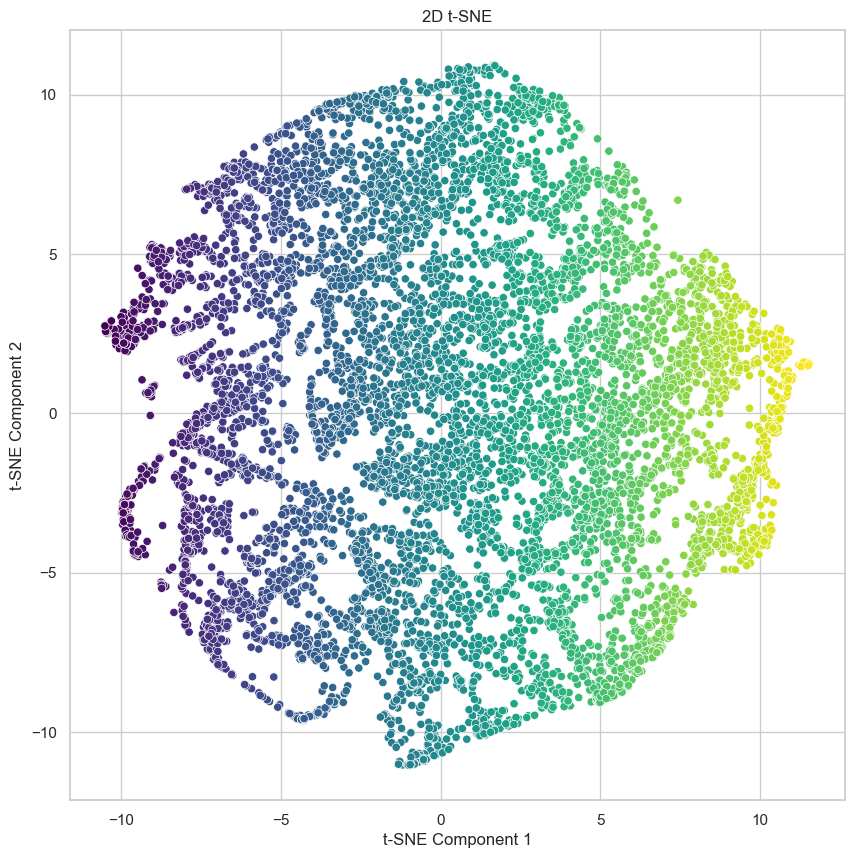

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8950 samples in 0.003s...
[t-SNE] Computed neighbors for 8950 samples in 0.694s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8950
[t-SNE] Computed conditional probabilities for sample 2000 / 8950
[t-SNE] Computed conditional probabilities for sample 3000 / 8950
[t-SNE] Computed conditional probabilities for sample 4000 / 8950
[t-SNE] Computed conditional probabilities for sample 5000 / 8950
[t-SNE] Computed conditional probabilities for sample 6000 / 8950
[t-SNE] Computed conditional probabilities for sample 7000 / 8950
[t-SNE] Computed conditional probabilities for sample 8000 / 8950
[t-SNE] Computed conditional probabilities for sample 8950 / 8950
[t-SNE] Mean sigma: 0.501191
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.303024
[t-SNE] KL divergence after 300 iterations: 2.144785


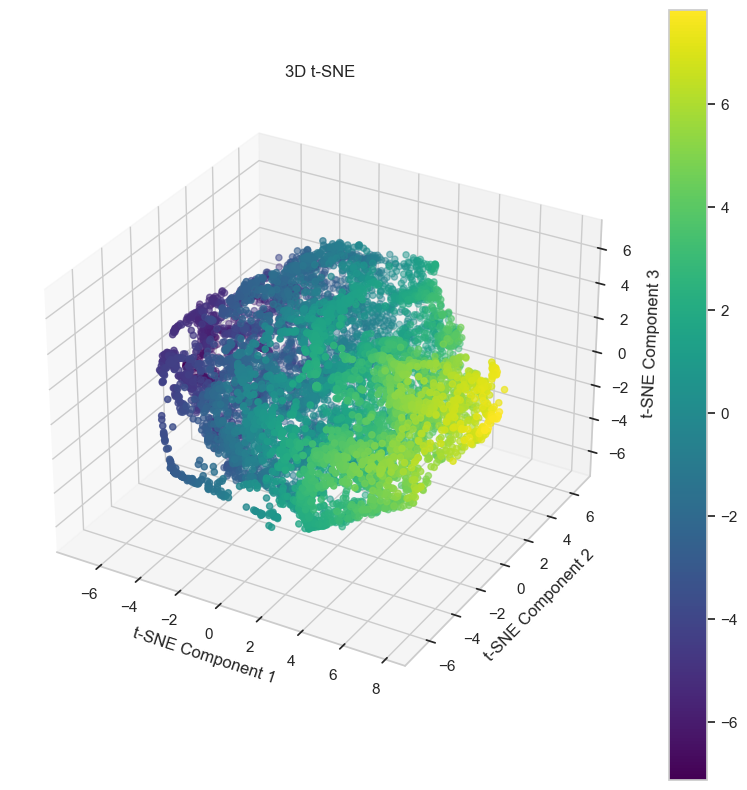

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

def scale_data(df):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    return df_scaled

def pca_2d_visualization(df_scaled):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df_scaled)
    PCA_dataset = pd.DataFrame(data=principalComponents, columns=['component1', 'component2'])
    plt.figure(figsize=(10, 10))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('2 Component PCA')
    sns.scatterplot(x='component1', y='component2', data=PCA_dataset, palette='viridis', hue='component1', legend=False)
    plt.show()

def tsne_2d_visualization(df_scaled, perplexity=40, n_iter=300):
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=n_iter)
    tsne_results = tsne.fit_transform(df_scaled)
    TSNE_dataset = pd.DataFrame(data=tsne_results, columns=['tsne_component1', 'tsne_component2'])
    plt.figure(figsize=(10, 10))
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('2D t-SNE')
    sns.scatterplot(x='tsne_component1', y='tsne_component2', data=TSNE_dataset, palette='viridis', hue='tsne_component1', legend=False)
    plt.show()

def tsne_3d_visualization(df_scaled, perplexity=40, n_iter=300):
    tsne = TSNE(n_components=3, verbose=1, perplexity=perplexity, n_iter=n_iter)
    tsne_results = tsne.fit_transform(df_scaled)
    TSNE_dataset = pd.DataFrame(data=tsne_results, columns=['tsne_component1', 'tsne_component2', 'tsne_component3'])
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    plt.title('3D t-SNE')
    scatter = ax.scatter(xs=TSNE_dataset['tsne_component1'], 
                         ys=TSNE_dataset['tsne_component2'], 
                         zs=TSNE_dataset['tsne_component3'], 
                         c=TSNE_dataset['tsne_component1'], 
                         cmap='viridis')
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_zlabel('t-SNE Component 3')
    plt.colorbar(scatter)
    plt.show()
df_scaled = scale_data(df)
pca_2d_visualization(df_scaled)
tsne_2d_visualization(df_scaled)
tsne_3d_visualization(df_scaled)


# Mean Shift Clustering

Silhouette Score: 0.5191
Davies-Bouldin Index: 0.7204
Calinski-Harabasz Index: 14909.9978


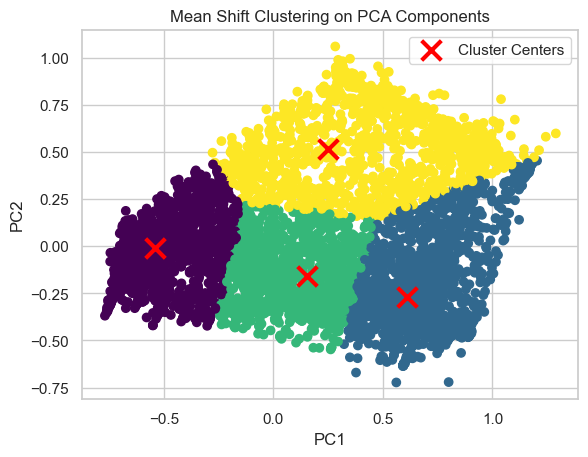

In [31]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# PCA function
def pca_selection(df):
    """
    Applies PCA on the dataset after encoding categorical features.
    Args:
        df (DataFrame): Input dataset.
    Returns:
        DataFrame: Transformed dataset with PCA components.
    """
    # Ensure all categorical columns are encoded
    cat_var = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
    if cat_var:
        label_encoder = LabelEncoder()
        for feature in cat_var:
            df[feature] = label_encoder.fit_transform(df[feature])

    # Apply PCA
    pca = PCA(random_state=123)
    pca_result = pca.fit_transform(df)

    # Create a DataFrame for PCA components
    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
    return pca_df


df = pd.DataFrame(df)

# Step 1: Apply PCA
pca_df = pca_selection(df)

# Step 2: Apply Mean Shift clustering
mean_shift = MeanShift()
clusters = mean_shift.fit_predict(pca_df[['PC1', 'PC2']])

# Step 3: Evaluate clustering metrics
silhouette_avg = silhouette_score(pca_df[['PC1', 'PC2']], clusters)
print(f"Silhouette Score: {silhouette_avg:.4f}")

db_index = davies_bouldin_score(pca_df[['PC1', 'PC2']], clusters)
print(f"Davies-Bouldin Index: {db_index:.4f}")

ch_index = calinski_harabasz_score(pca_df[['PC1', 'PC2']], clusters)
print(f"Calinski-Harabasz Index: {ch_index:.4f}")

# Step 4: Visualize results
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=clusters, cmap='viridis', marker='o')
plt.scatter(mean_shift.cluster_centers_[:, 0], mean_shift.cluster_centers_[:, 1], 
            c='red', marker='x', s=200, linewidths=3, label='Cluster Centers')
plt.title('Mean Shift Clustering on PCA Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


# HYPERPARAMTER TUNING

Bandwidth: 0.50 | Silhouette: 0.5245 | Davies-Bouldin: 0.7130 | Calinski-Harabasz: 15747.1721
Bandwidth: 0.67 | Silhouette: 0.5735 | Davies-Bouldin: 0.6618 | Calinski-Harabasz: 15827.2230
Bandwidth: 0.83 | Silhouette: -1.0000 | Davies-Bouldin: inf | Calinski-Harabasz: -1.0000
Bandwidth: 1.00 | Silhouette: -1.0000 | Davies-Bouldin: inf | Calinski-Harabasz: -1.0000
Bandwidth: 1.17 | Silhouette: -1.0000 | Davies-Bouldin: inf | Calinski-Harabasz: -1.0000
Bandwidth: 1.33 | Silhouette: -1.0000 | Davies-Bouldin: inf | Calinski-Harabasz: -1.0000
Bandwidth: 1.50 | Silhouette: -1.0000 | Davies-Bouldin: inf | Calinski-Harabasz: -1.0000
Bandwidth: 1.67 | Silhouette: -1.0000 | Davies-Bouldin: inf | Calinski-Harabasz: -1.0000
Bandwidth: 1.83 | Silhouette: -1.0000 | Davies-Bouldin: inf | Calinski-Harabasz: -1.0000
Bandwidth: 2.00 | Silhouette: -1.0000 | Davies-Bouldin: inf | Calinski-Harabasz: -1.0000

Best Bandwidth: 0.6666666666666666


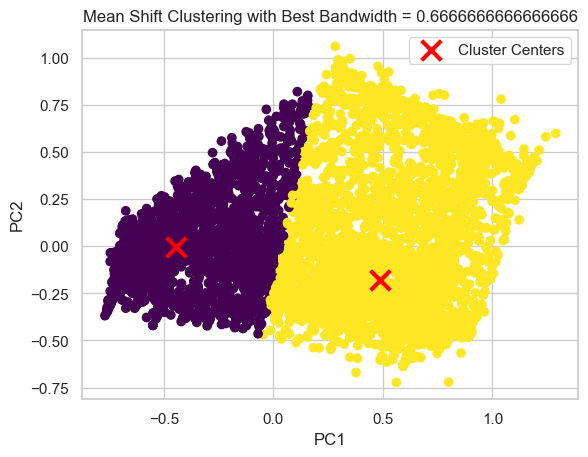

In [32]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# PCA function
def pca_selection(df):
    """
    Applies PCA on the dataset after encoding categorical features.
    Args:
        df (DataFrame): Input dataset.
    Returns:
        DataFrame: Transformed dataset with PCA components.
    """
    # Ensure all categorical columns are encoded
    cat_var = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
    if cat_var:
        label_encoder = LabelEncoder()
        for feature in cat_var:
            df[feature] = label_encoder.fit_transform(df[feature])

    # Apply PCA
    pca = PCA(random_state=123)
    pca_result = pca.fit_transform(df)

    # Create a DataFrame for PCA components
    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
    return pca_df

# Hyperparameter tuning function
def tune_mean_shift(pca_df, bandwidths):
    """
    Tunes the Mean Shift clustering bandwidth and evaluates clustering performance.
    Args:
        pca_df (DataFrame): PCA-transformed dataset.
        bandwidths (list): List of bandwidth values to evaluate.
    Returns:
        dict: Results containing metrics for each bandwidth.
    """
    results = {}
    for bandwidth in bandwidths:
        mean_shift = MeanShift(bandwidth=bandwidth)
        labels = mean_shift.fit_predict(pca_df[['PC1', 'PC2']])

        # Calculate metrics
        if len(set(labels)) > 1:  # Ensure there is more than one cluster
            silhouette_avg = silhouette_score(pca_df[['PC1', 'PC2']], labels)
            db_index = davies_bouldin_score(pca_df[['PC1', 'PC2']], labels)
            ch_index = calinski_harabasz_score(pca_df[['PC1', 'PC2']], labels)
        else:  # Single cluster results are not meaningful
            silhouette_avg, db_index, ch_index = -1, np.inf, -1

        # Save results
        results[bandwidth] = {
            'Silhouette Score': silhouette_avg,
            'Davies-Bouldin Index': db_index,
            'Calinski-Harabasz Index': ch_index,
            'Cluster Centers': mean_shift.cluster_centers_,
            'Labels': labels
        }
        print(f"Bandwidth: {bandwidth:.2f} | Silhouette: {silhouette_avg:.4f} | "
              f"Davies-Bouldin: {db_index:.4f} | Calinski-Harabasz: {ch_index:.4f}")
    return results

df = pd.DataFrame(df)
df1=df.copy()
# Step 1: Apply PCA
pca_df = pca_selection(df)

# Step 2: Define a range of bandwidths to test
bandwidths = np.linspace(0.5, 2.0, 10)

# Step 3: Perform hyperparameter tuning
results = tune_mean_shift(pca_df, bandwidths)

# Step 4: Find the best bandwidth based on Silhouette Score
best_bandwidth = max(results, key=lambda bw: results[bw]['Silhouette Score'])
print(f"\nBest Bandwidth: {best_bandwidth}")

# Step 5: Visualize the best clustering
best_labels = results[best_bandwidth]['Labels']
best_centers = results[best_bandwidth]['Cluster Centers']

plt.scatter(pca_df['PC1'], pca_df['PC2'], c=best_labels, cmap='viridis', marker='o')
plt.scatter(best_centers[:, 0], best_centers[:, 1], 
            c='red', marker='x', s=200, linewidths=3, label='Cluster Centers')
plt.title('Mean Shift Clustering with Best Bandwidth = {}'.format(best_bandwidth))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


# INTERPRETATION

The best bandwidth of 0.67 achieves a well-separated and cohesive clustering structure, as reflected by high Silhouette and Calinski-Harabasz scores and a low Davies-Bouldin Index.

The results indicate clear differentiation in the dataset, which can be used for targeted analysis or interventions based on cluster-specific characteristics.

# RADAR CHART

Silhouette Score: 0.7235
Davies-Bouldin Index: 0.4304
Calinski-Harabasz Index: 36056.0952


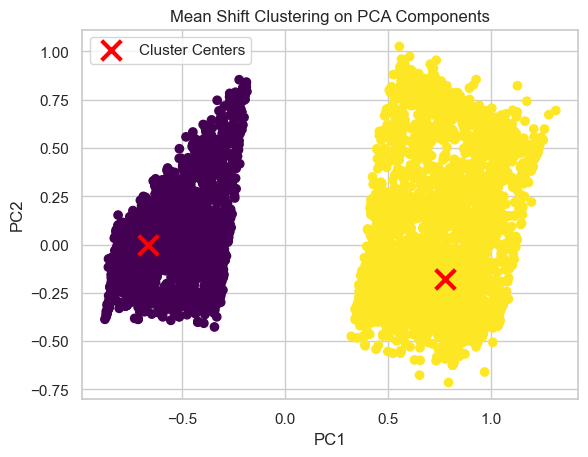

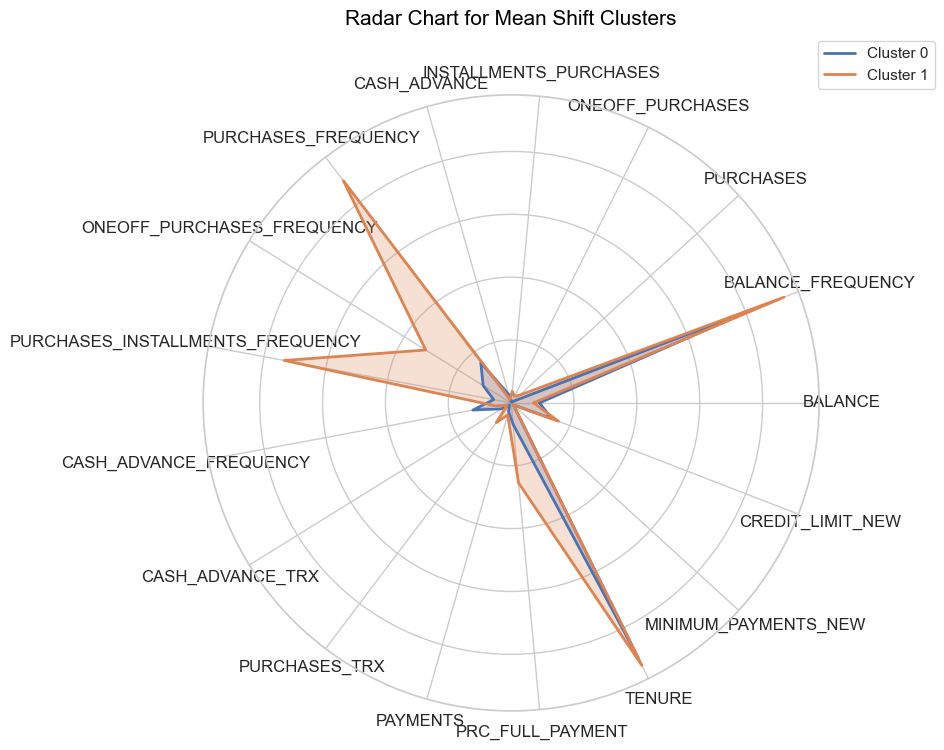

In [41]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# PCA function
def pca_selection(df):
    """
    Applies PCA on the dataset after encoding categorical features.
    Args:
        df (DataFrame): Input dataset.
    Returns:
        DataFrame: Transformed dataset with PCA components.
    """
    # Encode categorical columns
    cat_var = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
    if cat_var:
        label_encoder = LabelEncoder()
        for feature in cat_var:
            df[feature] = label_encoder.fit_transform(df[feature])

    # Apply PCA
    pca = PCA(random_state=123)
    pca_result = pca.fit_transform(df)

    # Create a DataFrame for PCA components
    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
    return pca_df

# Function to plot radar chart for a given cluster type
def plot_radar_chart(df, cluster_column, title='Radar Chart'):
    # Calculate the mean of each feature by cluster
    cluster_means = df.groupby(cluster_column).mean()
    
    # Define labels (features) and number of variables
    labels = cluster_means.columns
    num_vars = len(labels)
    
    # Setup angles for radar chart (spaced equally around a circle)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop
    
    # Plot radar chart for each cluster
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    for idx, row in cluster_means.iterrows():
        values = row.tolist()
        values += values[:1]  # Complete the loop
        ax.plot(angles, values, label=f'Cluster {idx}', linewidth=2)
        ax.fill(angles, values, alpha=0.25)
    
    # Customize chart appearance
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_yticklabels([])
    ax.set_title(title, size=15, color='black', y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    
    plt.show()

# Step 1: Prepare your dataset (replace this with your actual dataset)
df = pd.DataFrame(df)  # Replace 'df' with your actual data
df1 = df.copy()

# Step 2: Apply PCA
pca_df = pca_selection(df)

# Step 3: Apply Mean Shift Clustering
mean_shift = MeanShift(bandwidth=0.66)  # Specify bandwidth explicitly
clusters = mean_shift.fit_predict(pca_df[['PC1', 'PC2']])

# Step 4: Add the cluster labels as a new column in df1
df1['MeanShift_Cluster'] = clusters

# Step 5: Evaluate clustering metrics
silhouette_avg = silhouette_score(pca_df[['PC1', 'PC2']], clusters)
print(f"Silhouette Score: {silhouette_avg:.4f}")

db_index = davies_bouldin_score(pca_df[['PC1', 'PC2']], clusters)
print(f"Davies-Bouldin Index: {db_index:.4f}")

ch_index = calinski_harabasz_score(pca_df[['PC1', 'PC2']], clusters)
print(f"Calinski-Harabasz Index: {ch_index:.4f}")

# Step 6: Visualize Mean Shift Clustering
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=clusters, cmap='viridis', marker='o')
plt.scatter(mean_shift.cluster_centers_[:, 0], mean_shift.cluster_centers_[:, 1], 
            c='red', marker='x', s=200, linewidths=3, label='Cluster Centers')
plt.title('Mean Shift Clustering on PCA Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

# Step 7: Plot Radar Chart for Mean Shift Clusters
plot_radar_chart(df1, 'MeanShift_Cluster', title='Radar Chart for Mean Shift Clusters')


# CONCLUSION
Cluster 0 appears to represent individuals who make frequent purchases, including one-off and installment purchases, and also utilize cash advances

Cluster 1 seems to represent individuals with higher credit limits, larger balances, and a tendency to make larger minimum payments.

# PCA AND TSNE BEFORE AND  AFTER CLUSTERING

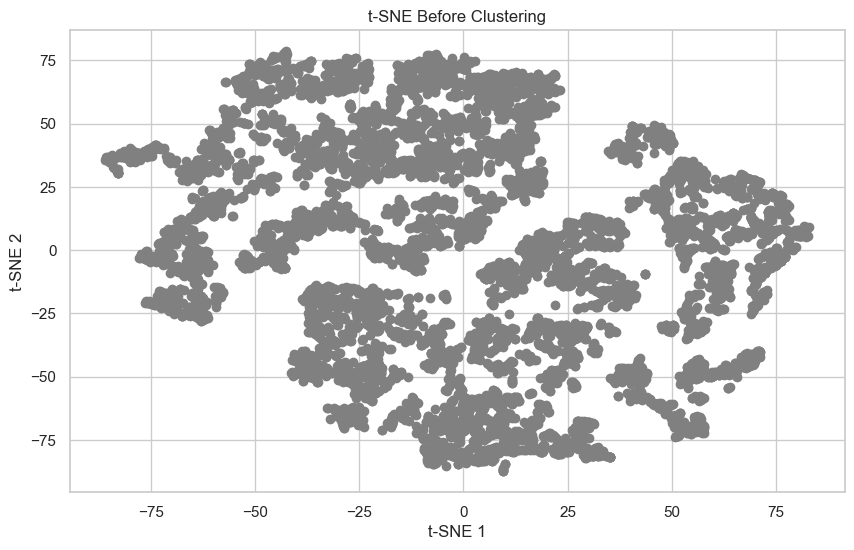

Silhouette Score: 0.7235
Davies-Bouldin Index: 0.4304
Calinski-Harabasz Index: 36056.0952


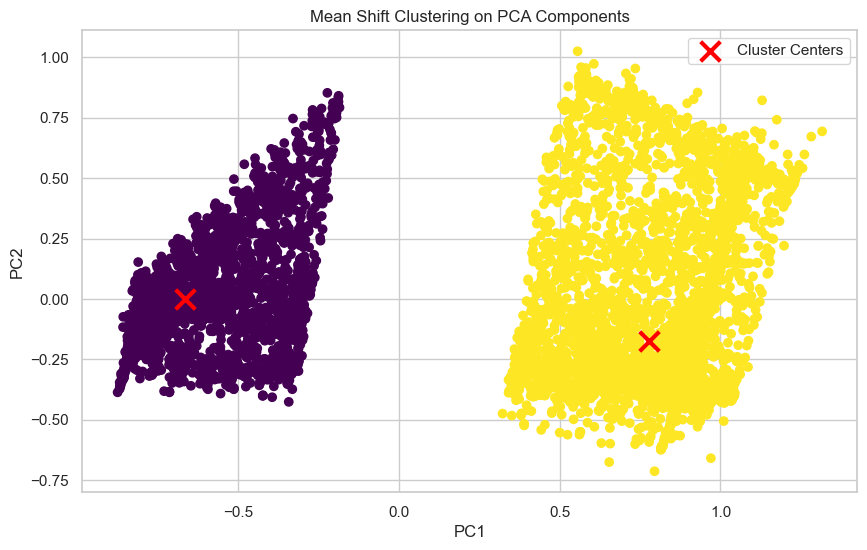

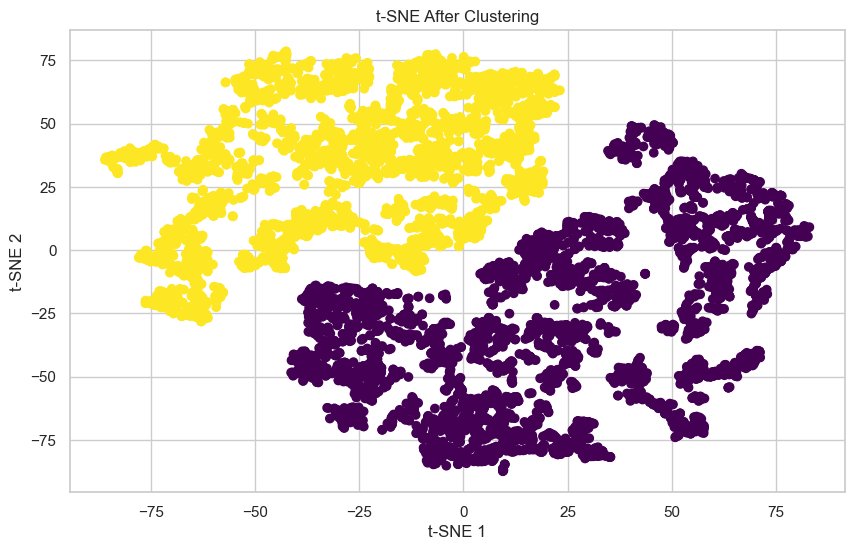

In [42]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# PCA function
def pca_selection(df):
    """
    Applies PCA on the dataset after encoding categorical features.
    Args:
        df (DataFrame): Input dataset.
    Returns:
        DataFrame: Transformed dataset with PCA components.
    """
    # Encode categorical columns
    cat_var = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
    if cat_var:
        label_encoder = LabelEncoder()
        for feature in cat_var:
            df[feature] = label_encoder.fit_transform(df[feature])

    # Apply PCA
    pca = PCA(random_state=123)
    pca_result = pca.fit_transform(df)

    # Create a DataFrame for PCA components
    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
    return pca_df

# Step 1: Prepare your dataset (replace this with your actual dataset)
df = pd.DataFrame(df)  # Replace 'df' with your actual data
df1 = df.copy()

# Step 2: Apply PCA
pca_df = pca_selection(df)

# Step 3: Apply t-SNE before clustering
tsne = TSNE(n_components=2, random_state=123, init='random', perplexity=30)
tsne_result = tsne.fit_transform(pca_df)

# Visualize t-SNE before clustering
plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='gray', marker='o')
plt.title('t-SNE Before Clustering')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.show()

# Step 4: Apply Mean Shift Clustering
mean_shift = MeanShift(bandwidth=0.66)  # Specify bandwidth explicitly
clusters = mean_shift.fit_predict(pca_df[['PC1', 'PC2']])

# Step 5: Add the cluster labels as a new column in df1
df1['MeanShift_Cluster'] = clusters

# Step 6: Evaluate clustering metrics
silhouette_avg = silhouette_score(pca_df[['PC1', 'PC2']], clusters)
print(f"Silhouette Score: {silhouette_avg:.4f}")

db_index = davies_bouldin_score(pca_df[['PC1', 'PC2']], clusters)
print(f"Davies-Bouldin Index: {db_index:.4f}")

ch_index = calinski_harabasz_score(pca_df[['PC1', 'PC2']], clusters)
print(f"Calinski-Harabasz Index: {ch_index:.4f}")

# Step 7: Visualize Mean Shift Clustering results on PCA components
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=clusters, cmap='viridis', marker='o')
plt.scatter(mean_shift.cluster_centers_[:, 0], mean_shift.cluster_centers_[:, 1], 
            c='red', marker='x', s=200, linewidths=3, label='Cluster Centers')
plt.title('Mean Shift Clustering on PCA Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

# Step 8: Apply t-SNE after clustering for visualization
tsne_result_after = TSNE(n_components=2, random_state=123, init='random', perplexity=30).fit_transform(pca_df)

# Visualize t-SNE after clustering
plt.figure(figsize=(10, 6))
plt.scatter(tsne_result_after[:, 0], tsne_result_after[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('t-SNE After Clustering')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.show()


# CONCLUSION

Based on the analysis, we can conclude that Mean Shift clustering outperforms DBSCAN and OPTICS, particularly in terms of cluster formation and adaptability to the underlying data structure. However, when compared to K-Means, the results appear to be comparable, suggesting that both algorithms perform similarly on this dataset. But Mean shift computationally  expensive 